#House Prices - Advanced Regression Techniques
##Predict sales prices and practice feature engineering, RFs, and gradient boosting

import libraries and data loading from Kaggle "house-prices-advanced-regression-techniques"
and loading data

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter("ignore")

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter("ignore")

from google.colab import drive
drive.mount('/content/gdrive')
# main_path = '/content/gdrive/Othercomputers/ה-מחשב נייד שלי/תואר שני/הסקה סטטיסטית וכריית נתונים/Assignments/HW2/Kaggle - House Prices/house-prices-advanced-regression-techniques'
main_path = '/content/gdrive/MyDrive/Statistical_Data_Mining/Assignment_2/house-prices-advanced-regression-techniques' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [118]:
train = pd.read_csv(main_path + '/train.csv')
test = pd.read_csv(main_path + '/test.csv')
submit = pd.read_csv(main_path + "/sample_submission.csv")

# Section 1: Database Overview and Visualization

In this section we will overview the database, understand it structure.

## 1.1 Data discription

We will make new database 'house_df' that is the concatinate of the test and train so wi can remove or add features to all the frames conveniently

In [119]:
print("train database:")
print("train shape:", train.shape)
# train['PoolQC'] == "Na"

train database:
train shape: (1460, 81)


In [120]:
print("test database:")
print("test shape:", test.shape)
test.head()

test database:
test shape: (1459, 80)


Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
0  1461          20       RH  ...    2010        WD        Normal
1  1462          20       RL  ...    2010        WD        Normal
2  1463          60       RL  ...    2010        WD        Normal
3  1464          60       RL  ...    2010        WD        Normal
4  1465         120       RL  ...    2010        WD        Normal

[5 rows x 80 columns]

In [121]:
house_df = pd.concat([train,test],ignore_index = True, sort = False)
tr_idx = house_df['SalePrice'].notnull() ## display data with on
te_idx = [not elem for elem in tr_idx]
te_idx = pd.Series(te_idx)
print("house dataframe shape:{}".format(house_df.shape))

house dataframe shape:(2919, 81)


## 1.2 Features type distribution

There are 81 diffrent feature, that is a lot of data to handle and process. Additionally, the feature are in diffrent type, not all of them are numerical, they can be splited according to type: 
1. int - 26 features
2. float64 - 12 features
3. object - 43 features

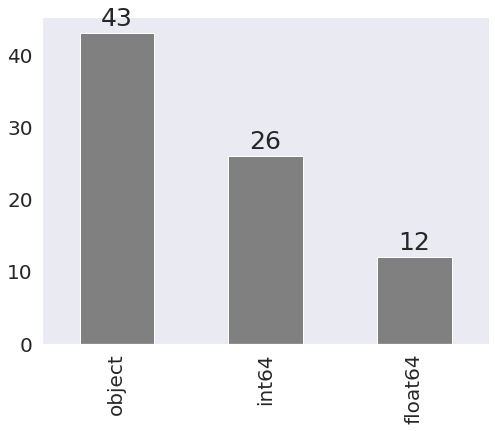

In [122]:
plt.figure(figsize = (8,6))
ax = house_df.dtypes.value_counts().plot(kind='bar',grid = False,fontsize=20,color='grey')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 1, height, ha = 'center', size = 25)
sns.despine()

Statistical description of the numerical features

In [123]:
# Amit: I think this part irellevent duo to lack of normalization step. It would be better if we normalize and reference this subsection 
house_df.describe().T.style.set_properties(**{'background-color': 'Grey',
                           'color': 'white',
                           'border-color': 'darkblack'})

## 1.3 Feature Histogram

Spliting the data according to the type from the previous subsection and ploting hitsograme for every feature to further understanding the numerical meaning behind the features.
It can be conclude from the histogram that:

1. **float64 features:**

  Three float64 features are in fact discrete variables:
  * BsmtHalfBath - Basement half bathrooms
  * BsmtFullBath - Basement full bathrooms
  * GarageCars - Size of garage in car capacity
  
  Some features have a skewed shape to one side.


2. **int features:**

  Five int features values does not represent quantitative sizes
  * MSSubClass - Identifies the type of dwelling involved in the sale.
  * YearBuilt - Original construction date
  * YearRemodAdd - Remodel date (same as construction date if no remodeling or additions)
  * MoSold - Month Sold (MM)
  * YrSold - Year Sold (YYYY)



In [201]:
def get_colums(dataset, change_col = True):
  # Select categorical columns
  categorical_cols = [cname for cname in dataset.loc[:,:'SaleCondition'].columns if
                      dataset[cname].nunique() < 200 and 
                      dataset[cname].dtype == "object"]

  # print("Number of Categorical fetures:",(len(categorical_cols)))
  # Select numerical columns
  int_cols = [cname for cname in dataset.loc[:,:'SaleCondition'].columns if 
                  dataset[cname].dtype in ['int64']]
      
  # print("Number of integer fetures:",(len(int_cols)))

  float_cols = [cname for cname in dataset.loc[:,:'SaleCondition'].columns if 
                  dataset[cname].dtype in ['float64']]
  # print("Number of float fetures:",(len(float_cols)))

  float2int_features = ['BsmtHalfBath', 'BsmtFullBath', 'GarageCars']
  int2cat_features = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'MoSold','YrSold']

  if change_col:
    # change float features to int
    for item in float2int_features:
      float_cols.remove(item)
      int_cols.append(item)
    # change int features to categorical
    for item in int2cat_features:
      int_cols.remove(item)
      categorical_cols.append(item)

  return categorical_cols, int_cols, float_cols

categorical_cols, int_cols, float_cols = get_colums(house_df)
print("Number of Categorical fetures:",(len(categorical_cols)))
print("Number of integer fetures:",(len(int_cols)))
print("Number of float fetures:",(len(float_cols)))

Number of Categorical fetures: 48
Number of integer fetures: 23
Number of float fetures: 8


int type features:


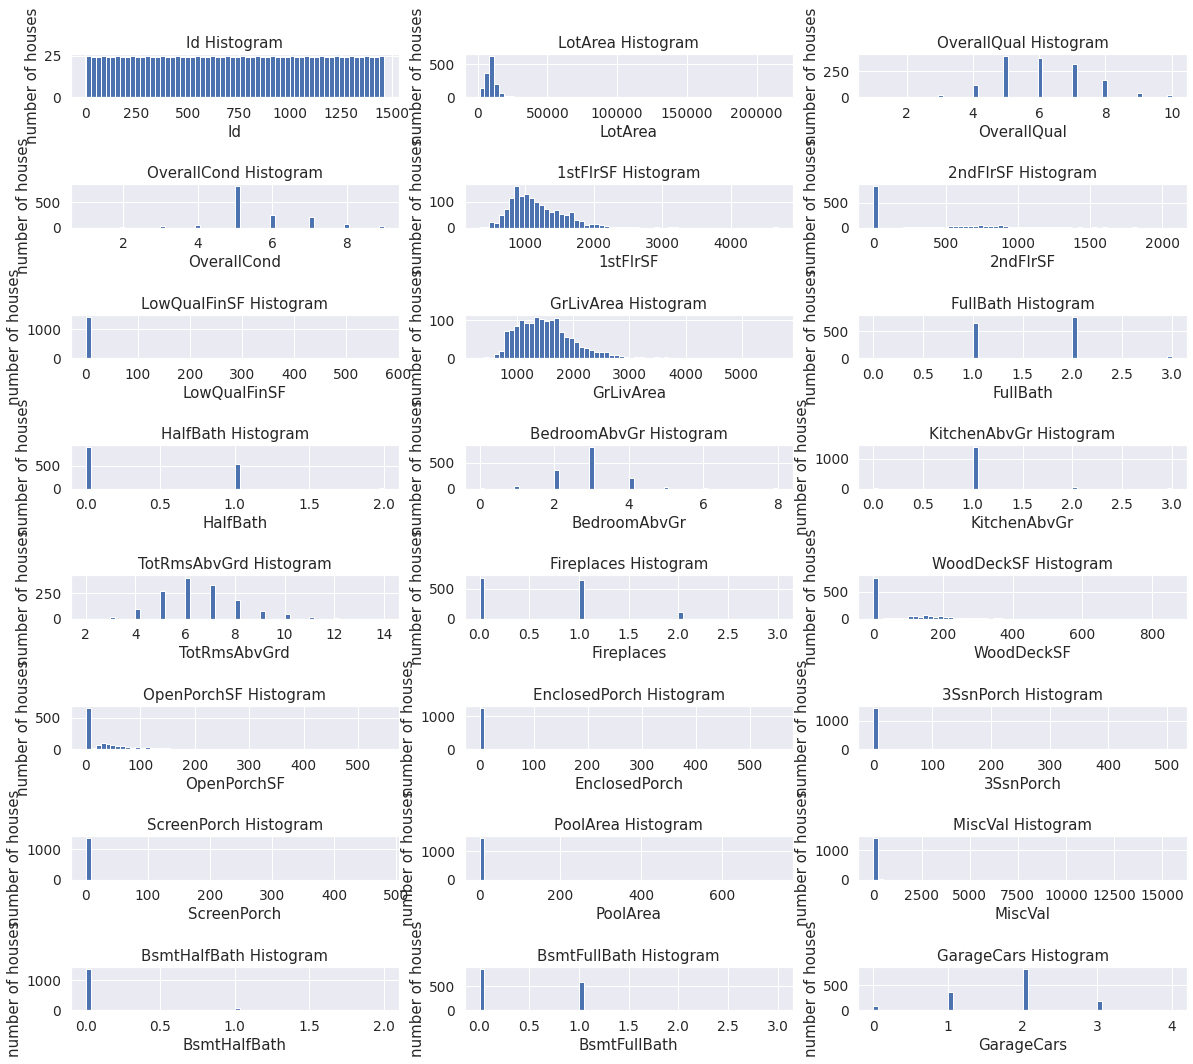

In [127]:
print("int type features:")
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=2)
for i, var in enumerate(int_cols):
    plt.subplot(9,3,i+1)
    fig = train[var].hist(bins=60)
    fig.set_ylabel('number of houses')
    fig.set_xlabel(var)
    str3= "".join([var,' Histogram'])
    fig.set_title(str3)


float type features:


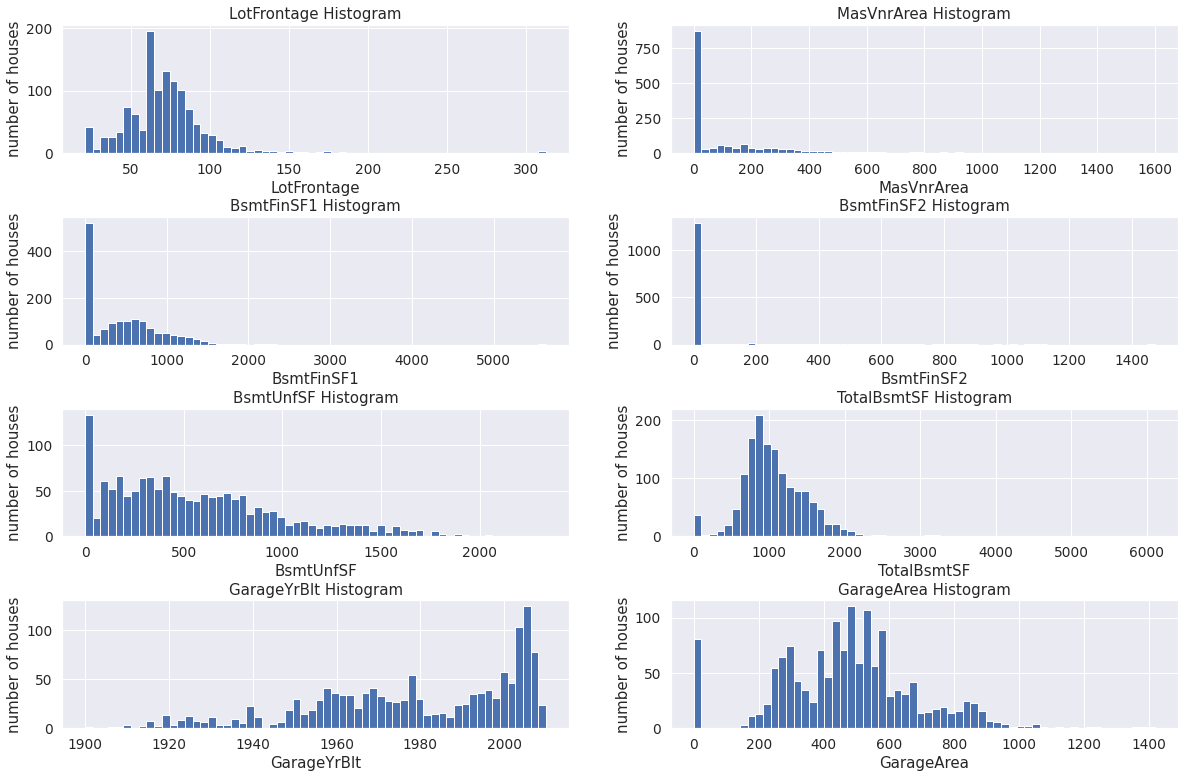

In [128]:
print("float type features:")
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
for i, var in enumerate(float_cols):
    plt.subplot(6,2,i+1)
    fig = train[var].hist(bins=60)
    fig.set_ylabel('number of houses')
    fig.set_xlabel(var)
    str3= "".join([var,' Histogram'])
    fig.set_title(str3)

Categorial type features:


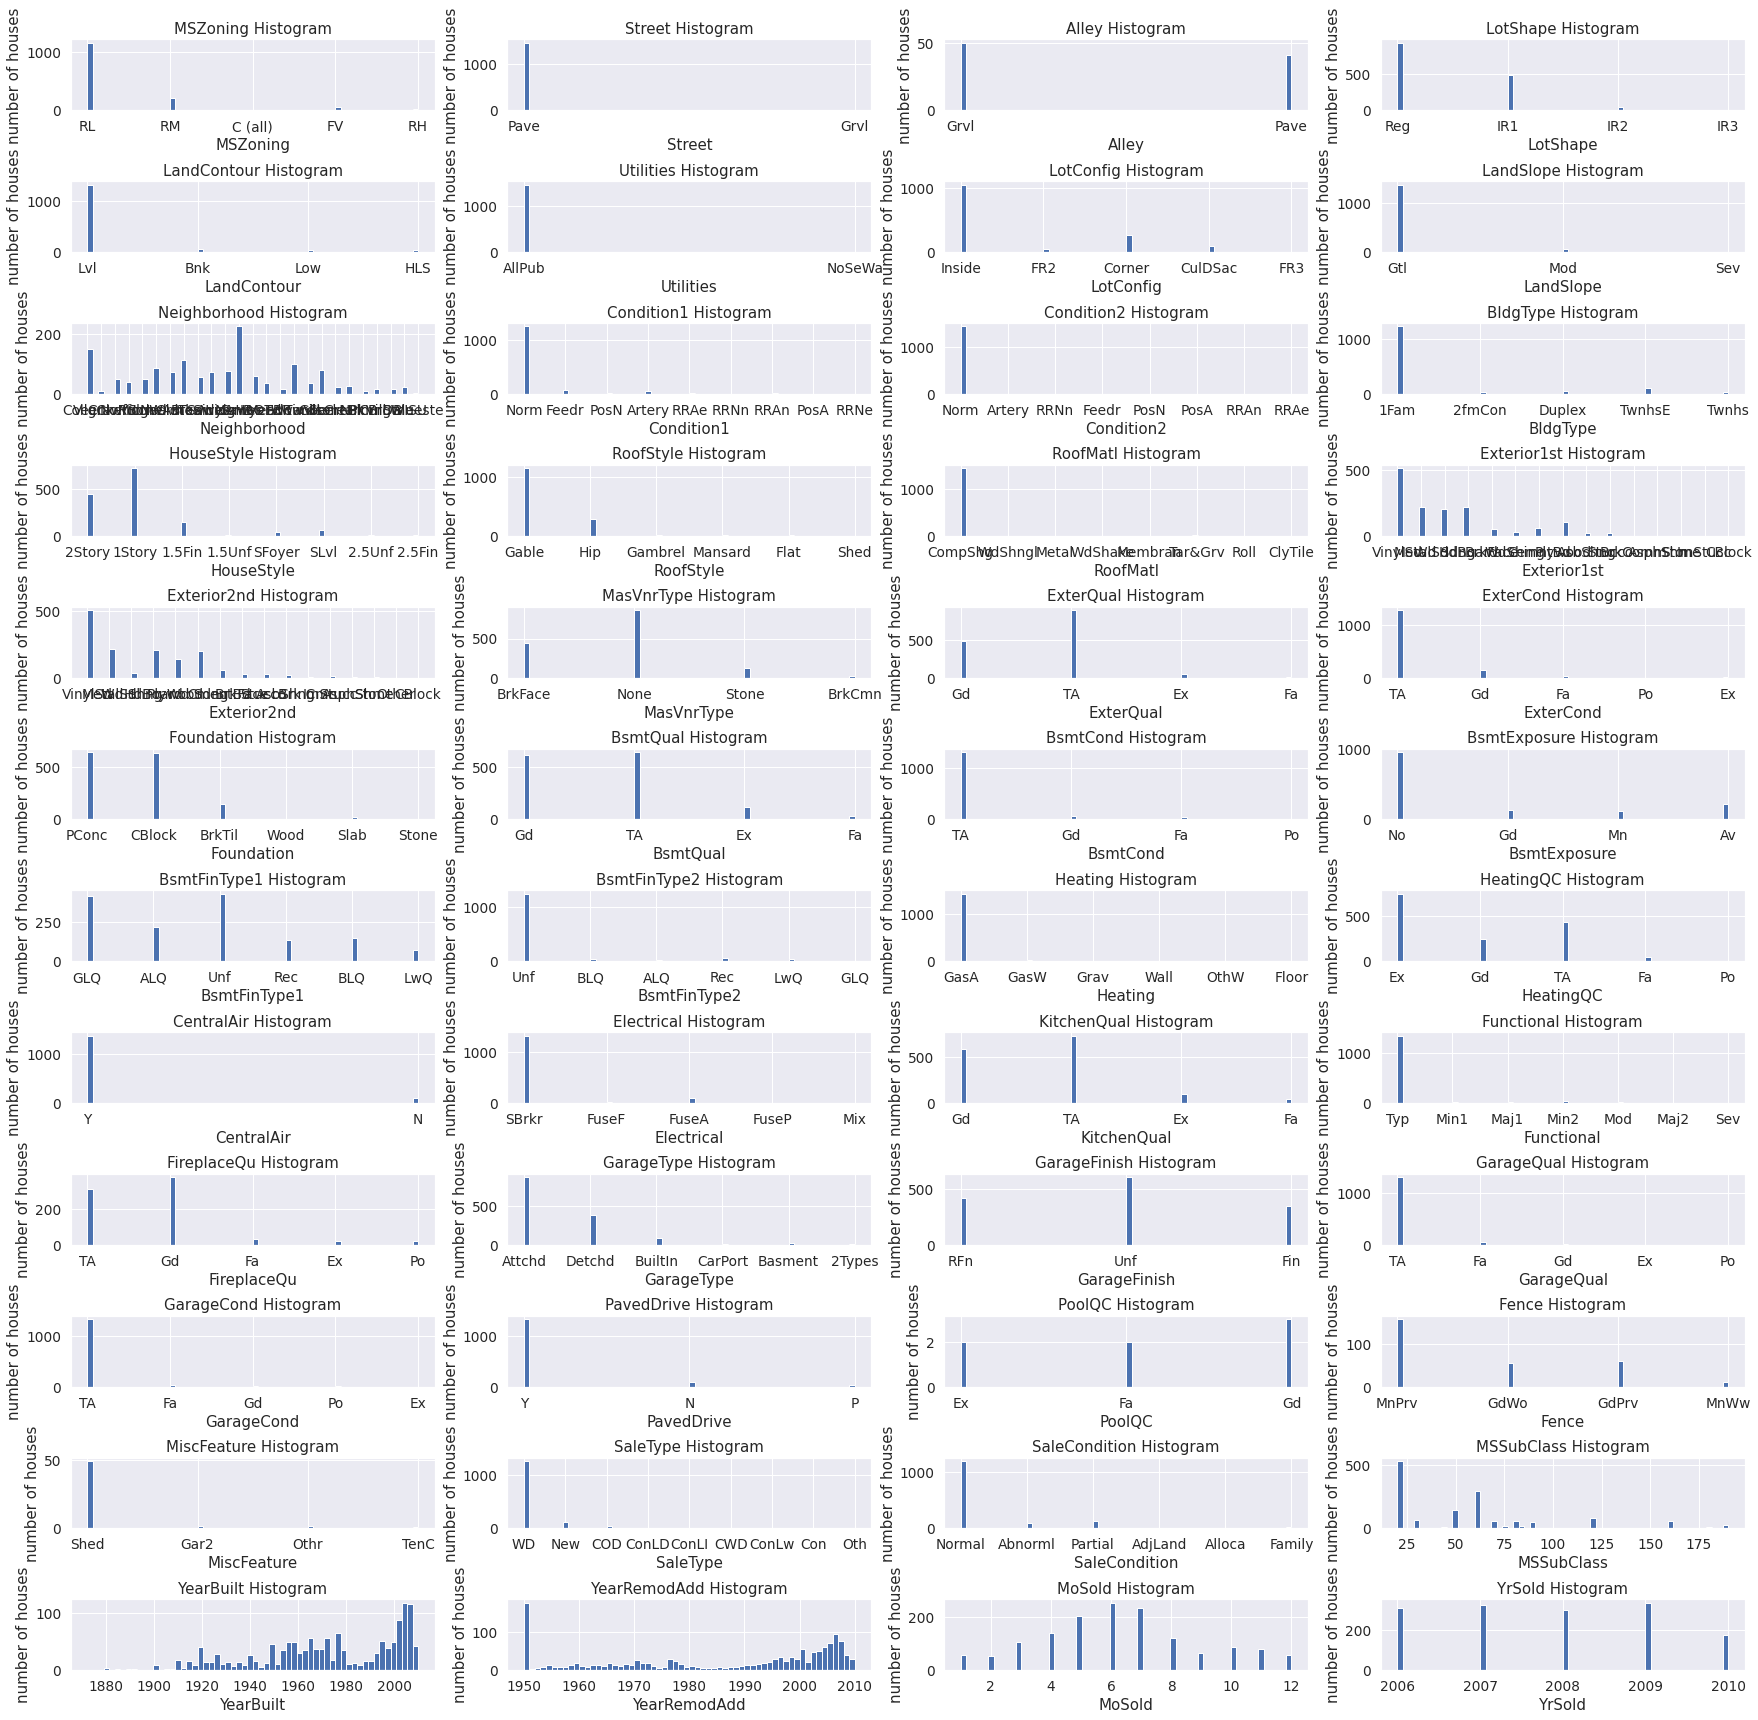

In [129]:
print("Categorial type features:")
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=1)
for i, var in enumerate(categorical_cols):
    plt.subplot(12,4,i+1)
    fig = train[var].hist(bins=60)
    fig.set_ylabel('number of houses')
    fig.set_xlabel(var)
    str3= "".join([var,' Histogram'])
    fig.set_title(str3)

factorize categorial values

## 1.4 Missing featurs

There are 17 fearute which dosent comprised from all samples in the dataframe:
* LotFrontage
* Alley
* BsmtQual
* MasVnrArea
* MasVnrArea
* BsmtCond
* BsmtExposure
* BsmtFinType1
* BsmtFinType2
* Electrical
* FireplaceQu     
* GarageType                                                           
* GarageCond       
* PoolQC         
* Fence          
* MiscFeature    

Train and Test missing data:

In [130]:
# house_df missing features
print("house_df missing features")
print("house_df shape: {}".format(train.shape))
pd.set_option('display.max_rows', None)
missing_data = pd.DataFrame(house_df.isna().sum())
missing_data_prec = missing_data/house_df.shape[0] * 100
missing_data = pd.concat([missing_data,missing_data_prec], axis=1)
missing_data.columns =['occurence', 'precentage']
print(missing_data)
pd.reset_option('all')

house_df missing features
house_df shape: (1460, 81)
               occurence  precentage
Id                     0    0.000000
MSSubClass             0    0.000000
MSZoning               4    0.137033
LotFrontage          486   16.649538
LotArea                0    0.000000
Street                 0    0.000000
Alley               2721   93.216855
LotShape               0    0.000000
LandContour            0    0.000000
Utilities              2    0.068517
LotConfig              0    0.000000
LandSlope              0    0.000000
Neighborhood           0    0.000000
Condition1             0    0.000000
Condition2             0    0.000000
BldgType               0    0.000000
HouseStyle             0    0.000000
OverallQual            0    0.000000
OverallCond            0    0.000000
YearBuilt              0    0.000000
YearRemodAdd           0    0.000000
RoofStyle              0    0.000000
RoofMatl               0    0.000000
Exterior1st            1    0.034258
Exterior2nd           

Train missing data:

In [131]:
# train missing features
print('train missing features')
print('train shape: {}'.format(train.shape[0]))
pd.set_option('display.max_rows', None)
missing_data = pd.DataFrame(train.isna().sum())
missing_data_prec = missing_data/train.shape[0] * 100
missing_data = pd.concat([missing_data,missing_data_prec], axis=1)
missing_data.columns =['occurence', 'precentage']
print(missing_data)
pd.reset_option('all')

train missing features
train shape: 1460
               occurence  precentage
Id                     0    0.000000
MSSubClass             0    0.000000
MSZoning               0    0.000000
LotFrontage          259   17.739726
LotArea                0    0.000000
Street                 0    0.000000
Alley               1369   93.767123
LotShape               0    0.000000
LandContour            0    0.000000
Utilities              0    0.000000
LotConfig              0    0.000000
LandSlope              0    0.000000
Neighborhood           0    0.000000
Condition1             0    0.000000
Condition2             0    0.000000
BldgType               0    0.000000
HouseStyle             0    0.000000
OverallQual            0    0.000000
OverallCond            0    0.000000
YearBuilt              0    0.000000
YearRemodAdd           0    0.000000
RoofStyle              0    0.000000
RoofMatl               0    0.000000
Exterior1st            0    0.000000
Exterior2nd            0    0.0000

***Most missing features are:***
1.   "Alley" with 93% of missing values
2.   "PoolQC" with 99.52% of missing values
3.   "Fence" with 80.75% of missing values
4.   "MiscFeature" with 96.3% of missing values




# Section 2: Feature Engineering



## 2.0 Missing Values

In [132]:
# house_df missing features
print("house_df missing features")
print("house_df shape: {}".format(train.shape))
pd.set_option('display.max_rows', None)
missing_data = pd.DataFrame(house_df.isna().sum())
missing_data_prec = missing_data/house_df.shape[0] * 100
missing_data = pd.concat([missing_data,missing_data_prec], axis=1)
missing_data.columns =['occurence', 'precentage']
print(missing_data)
pd.reset_option('all')

house_df missing features
house_df shape: (1460, 81)
               occurence  precentage
Id                     0    0.000000
MSSubClass             0    0.000000
MSZoning               4    0.137033
LotFrontage          486   16.649538
LotArea                0    0.000000
Street                 0    0.000000
Alley               2721   93.216855
LotShape               0    0.000000
LandContour            0    0.000000
Utilities              2    0.068517
LotConfig              0    0.000000
LandSlope              0    0.000000
Neighborhood           0    0.000000
Condition1             0    0.000000
Condition2             0    0.000000
BldgType               0    0.000000
HouseStyle             0    0.000000
OverallQual            0    0.000000
OverallCond            0    0.000000
YearBuilt              0    0.000000
YearRemodAdd           0    0.000000
RoofStyle              0    0.000000
RoofMatl               0    0.000000
Exterior1st            1    0.034258
Exterior2nd           

In [133]:
def Fmissing_featuers(data):
  Wrong_iden_Cat_features = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
                           "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
                           "GarageCond", "PoolQC", "Fence", "MiscFeature"]

  Wrong_iden_Num_features = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
                           'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars']
                           
  for feature in Wrong_iden_Cat_features:
    data[feature] = data[feature].fillna('None')

  for feature in Wrong_iden_Num_features:
    data[feature] = data[feature].fillna(0)
  return data
  data["Functional"] = data["Functional"].fillna("Typ")

train = Fmissing_featuers(train)
test = Fmissing_featuers(test)
house_df = pd.concat([train,test],ignore_index = True, sort = False)

After applying None to Featuers with Values NA

In [134]:
# house_df missing features
print("house_df missing features")
print("house_df shape: {}".format(train.shape))
pd.set_option('display.max_rows', None)
missing_data = pd.DataFrame(house_df.isna().sum())
missing_data_prec = missing_data/house_df.shape[0] * 100
missing_data = pd.concat([missing_data,missing_data_prec], axis=1)
missing_data.columns =['occurence', 'precentage']
print(missing_data)
pd.reset_option('all')

house_df missing features
house_df shape: (1460, 81)
               occurence  precentage
Id                     0    0.000000
MSSubClass             0    0.000000
MSZoning               4    0.137033
LotFrontage          486   16.649538
LotArea                0    0.000000
Street                 0    0.000000
Alley                  0    0.000000
LotShape               0    0.000000
LandContour            0    0.000000
Utilities              2    0.068517
LotConfig              0    0.000000
LandSlope              0    0.000000
Neighborhood           0    0.000000
Condition1             0    0.000000
Condition2             0    0.000000
BldgType               0    0.000000
HouseStyle             0    0.000000
OverallQual            0    0.000000
OverallCond            0    0.000000
YearBuilt              0    0.000000
YearRemodAdd           0    0.000000
RoofStyle              0    0.000000
RoofMatl               0    0.000000
Exterior1st            1    0.034258
Exterior2nd           

## 2.1 Dealing with Outliers

***outlier:***  a data point that is distant from other similar points.should be excluded from the data set. We'll do a quick analysis through the standard deviation of 'SalePrice' and a set of scatter plots.

In [135]:
def remove_Outlier(data, feature_name, value):
  idx = (data[feature_name] > value)
  index_list = list(data[idx].index)
  data = data.drop(index_list)
  return data

In [136]:
house_df[tr_idx] 

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0        1          60       RL  ...        WD         Normal  208500.0
1        2          20       RL  ...        WD         Normal  181500.0
2        3          60       RL  ...        WD         Normal  223500.0
3        4          70       RL  ...        WD        Abnorml  140000.0
4        5          60       RL  ...        WD         Normal  250000.0
...    ...         ...      ...  ...       ...            ...       ...
1455  1456          60       RL  ...        WD         Normal  175000.0
1456  1457          20       RL  ...        WD         Normal  210000.0
1457  1458          70       RL  ...        WD         Normal  266500.0
1458  1459          20       RL  ...        WD         Normal  142125.0
1459  1460          20       RL  ...        WD         Normal  147500.0

[1460 rows x 81 columns]

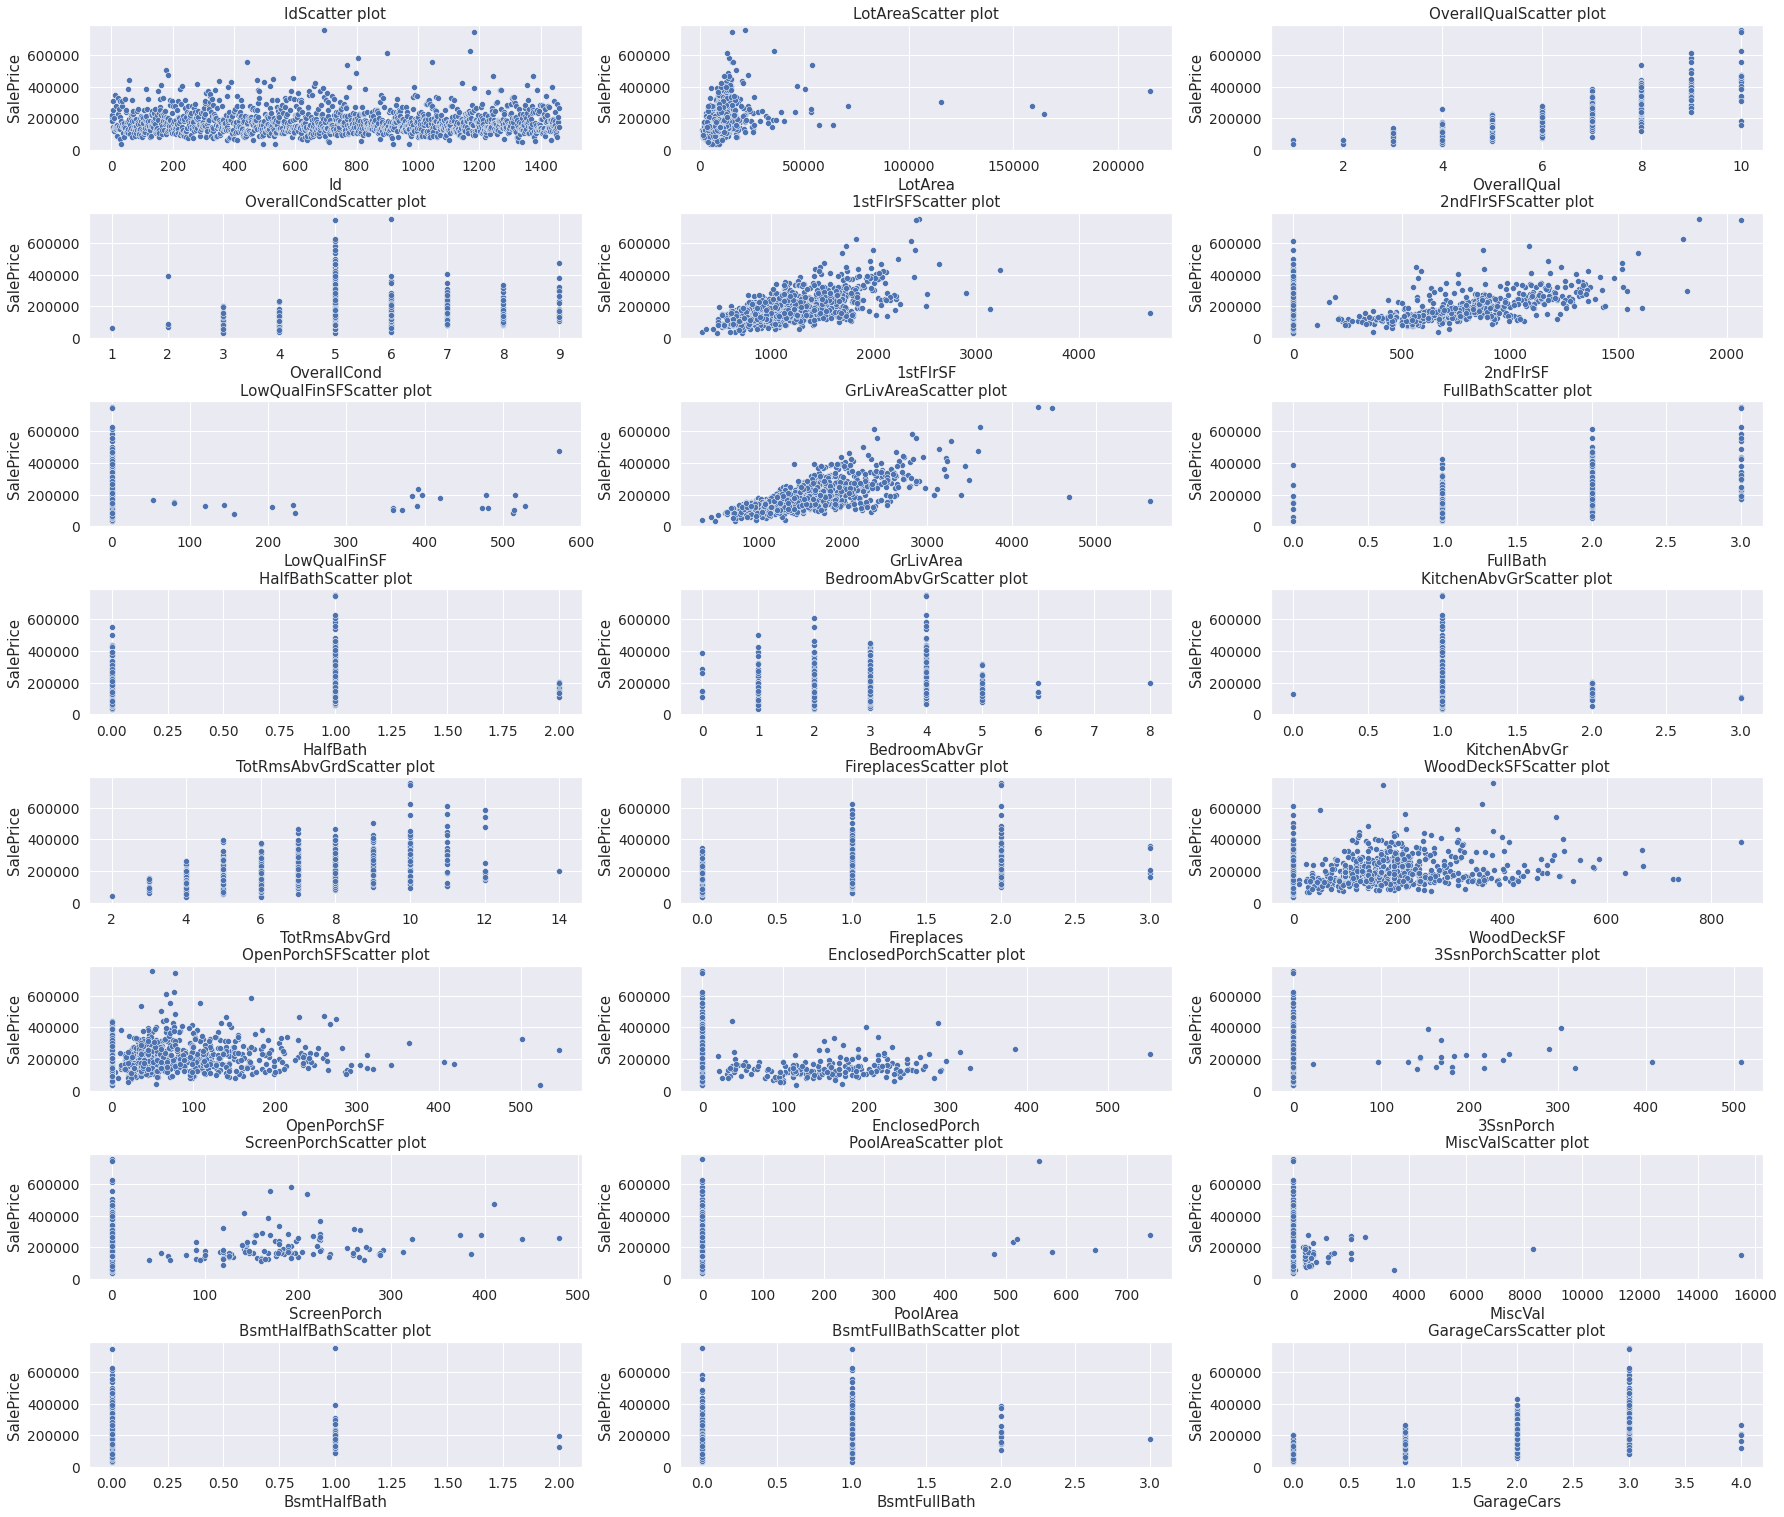

In [137]:
# int colums scatter plot
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.5)
for i, var in enumerate(int_cols):
  plt.subplot(9,3,i+1)
  fig = sns.scatterplot(data=train, x=var, y='SalePrice')
  fig.set_ylabel("SalePrice", labelpad = 5)
  fig.set_xlabel(var)
  str3= "".join([var,'Scatter plot'])
  fig.set_title(str3)
plt.show()


**lets Analyze where the outliers are hidding:**

by observing the scatter praphs above we can notice the following ouliers data points:

**For integer represented features**:

1. LotArea feature - over 100000
2. 1stFlrSF feature - over 2500
3. 2ndFlrSF feature - over 1750
4. GrLiveArea feature - over 4000
5. WoodDeckSF feature - over 700
6. PoolArea feature - over 400
7. MiscVal feature - over 8000
8. EnclosedPorch feature - over 350




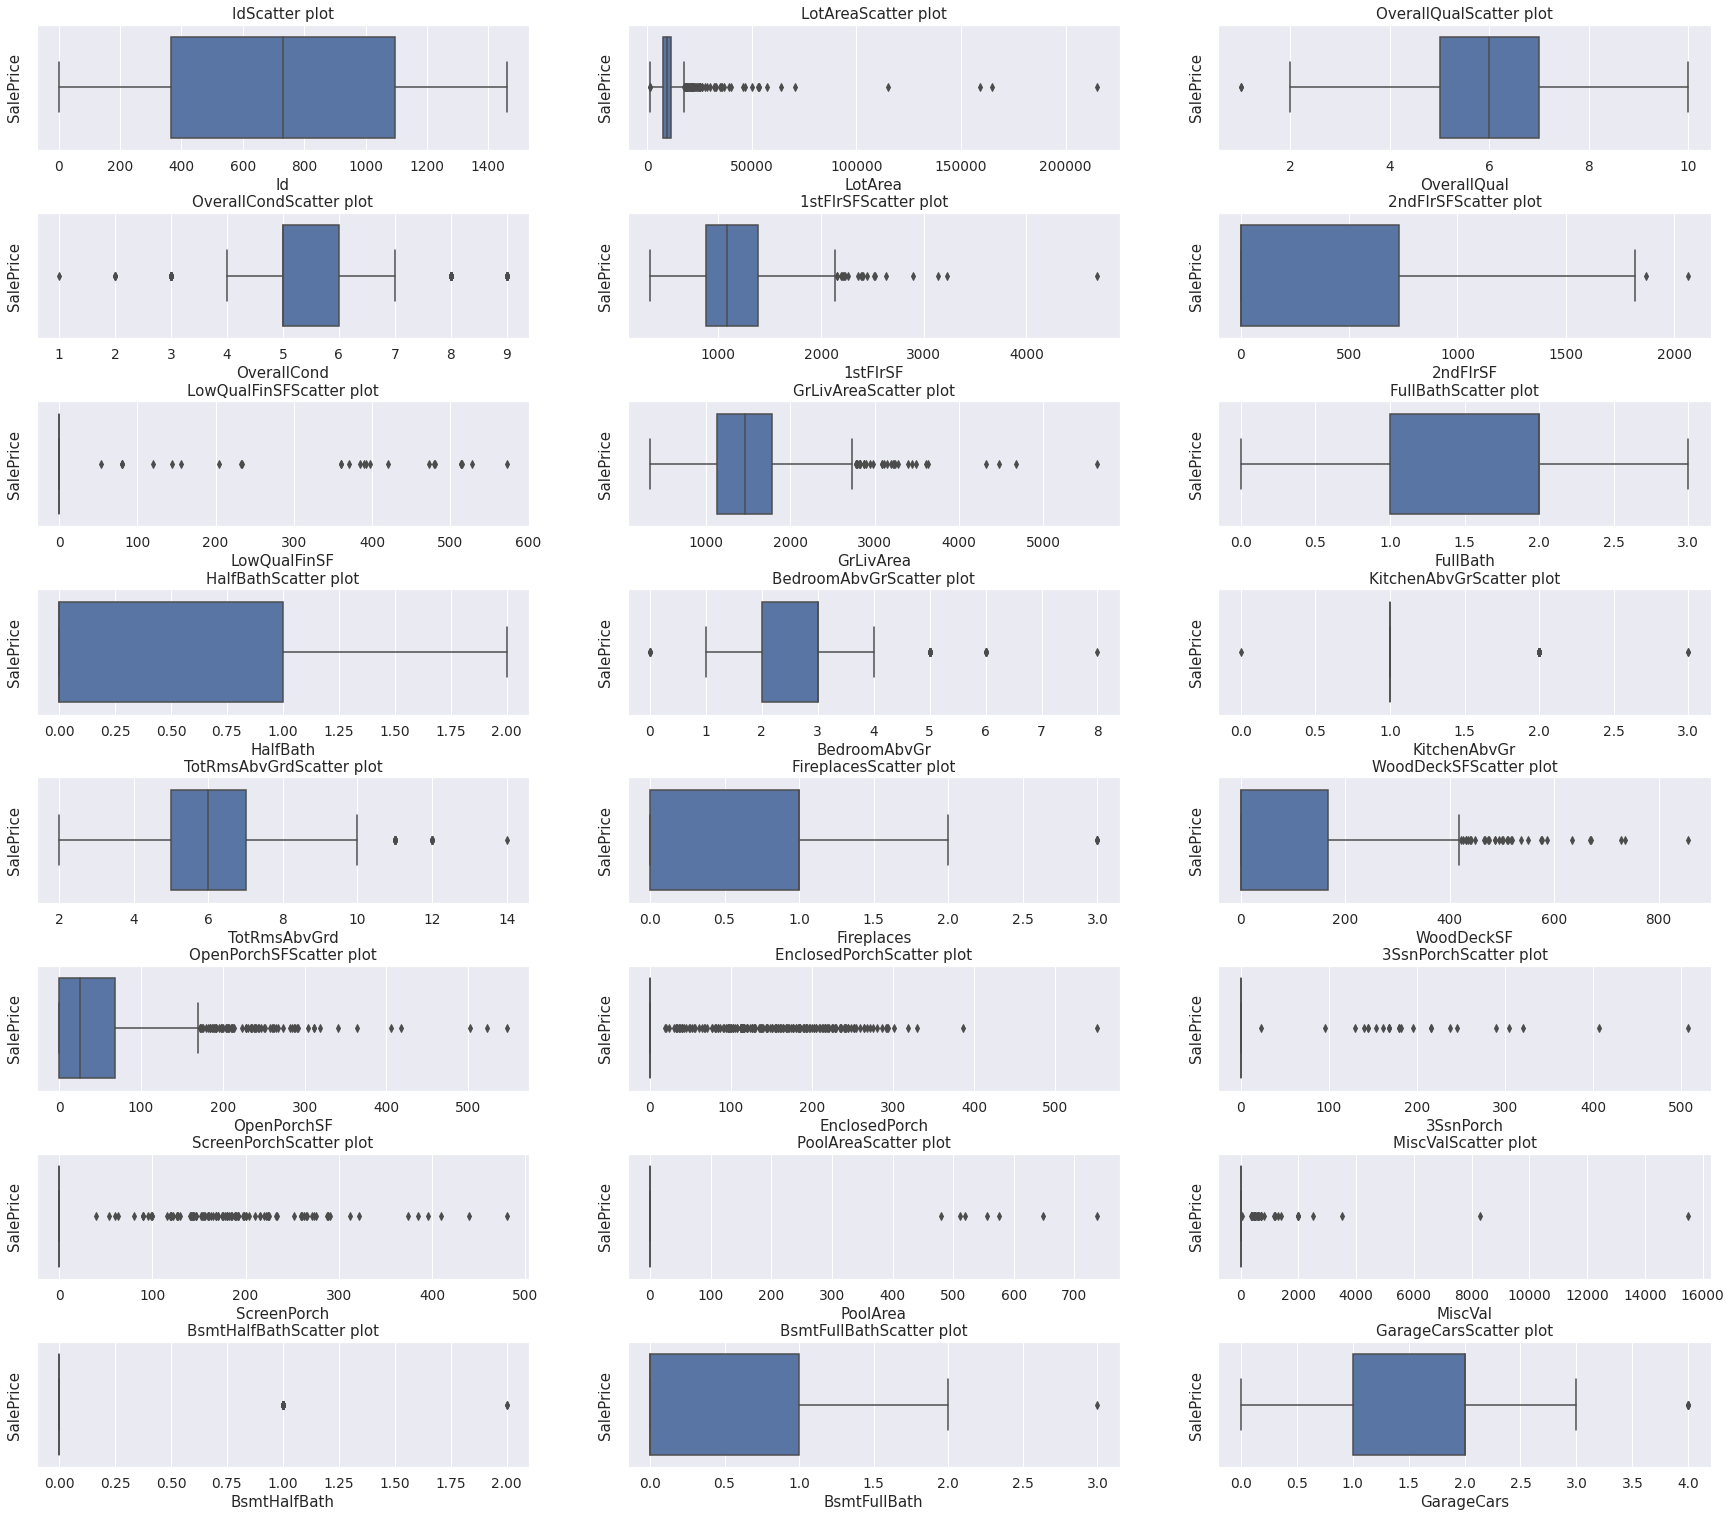

In [138]:
# int colums scatter plot
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.5)
for i, var in enumerate(int_cols):
  plt.subplot(9,3,i+1)
  fig = sns.boxplot(train[var])
  fig.set_ylabel("SalePrice", labelpad = 5)
  fig.set_xlabel(var)
  str3= "".join([var,'Scatter plot'])
  fig.set_title(str3)
plt.show()

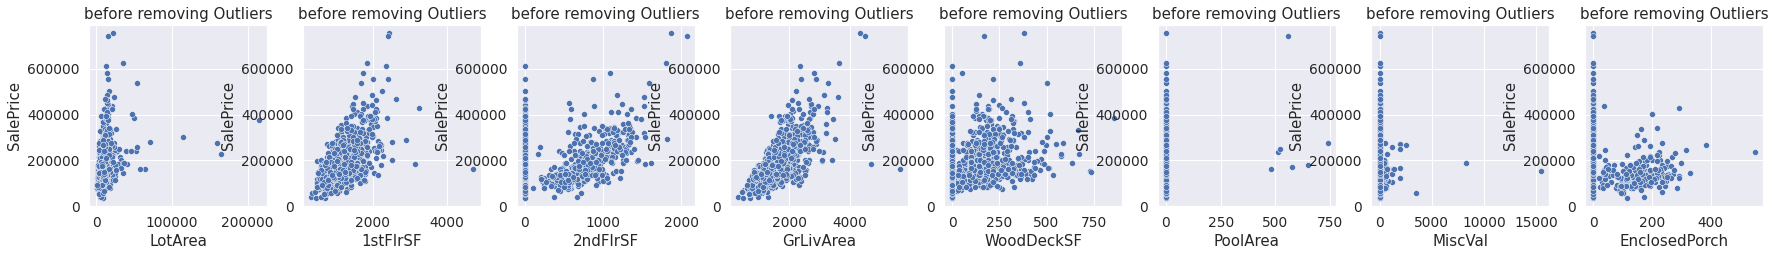

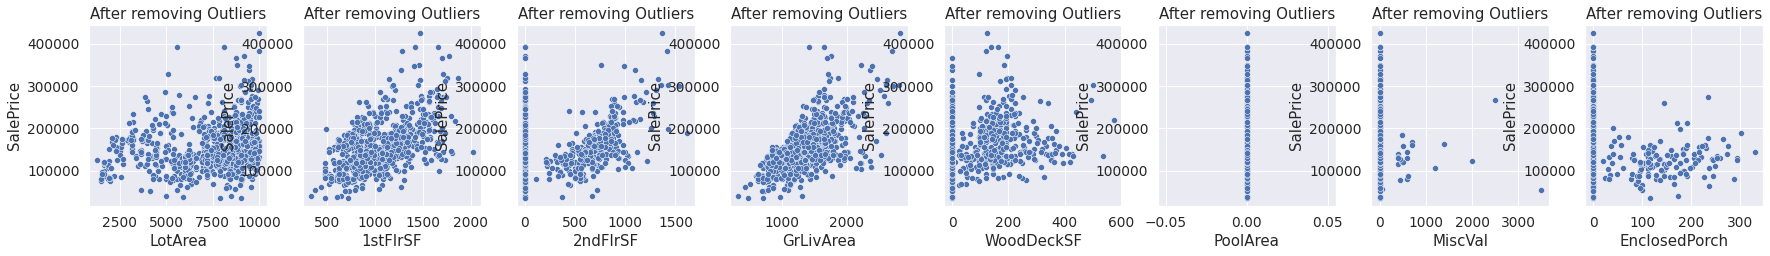

In [139]:
plt.figure(figsize=(30, 10))
plt.subplots_adjust(hspace=1)
for i, var in enumerate(["LotArea", "1stFlrSF", "2ndFlrSF", "GrLivArea", "WoodDeckSF", "PoolArea", "MiscVal", "EnclosedPorch"]):
  plt.subplot(2,8,i+1)
  fig = sns.scatterplot(data=house_df[tr_idx],x=var,y='SalePrice')
  fig.set_ylabel("SalePrice", labelpad = 5)
  fig.set_xlabel(var)
  fig.set_title("before removing Outliers")
plt.show()
# int cols
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "LotArea", 10000)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "1stFlrSF", 2500)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "2ndFlrSF", 1750)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "GrLivArea", 4000)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "WoodDeckSF", 700)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "PoolArea", 400)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "MiscVal", 8000)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "EnclosedPorch", 350)
### Optional ## shoule be tested
idx = ((house_df[tr_idx]["OverallQual"] == 4)  & (house_df[tr_idx]['SalePrice'] > 200000))
index_list = list(house_df[tr_idx][idx].index)
house_df[tr_idx] = house_df[tr_idx].drop(index_list)

plt.figure(figsize=(30, 10))
plt.subplots_adjust(hspace=1)
for i, var in enumerate(["LotArea", "1stFlrSF", "2ndFlrSF", "GrLivArea", "WoodDeckSF", "PoolArea", "MiscVal", "EnclosedPorch"]):
  plt.subplot(2,8,i+9)
  fig = sns.scatterplot(data=house_df[tr_idx],x=var,y='SalePrice')
  fig.set_ylabel("SalePrice", labelpad = 5)
  fig.set_xlabel(var)
  fig.set_title("After removing Outliers")
plt.show()

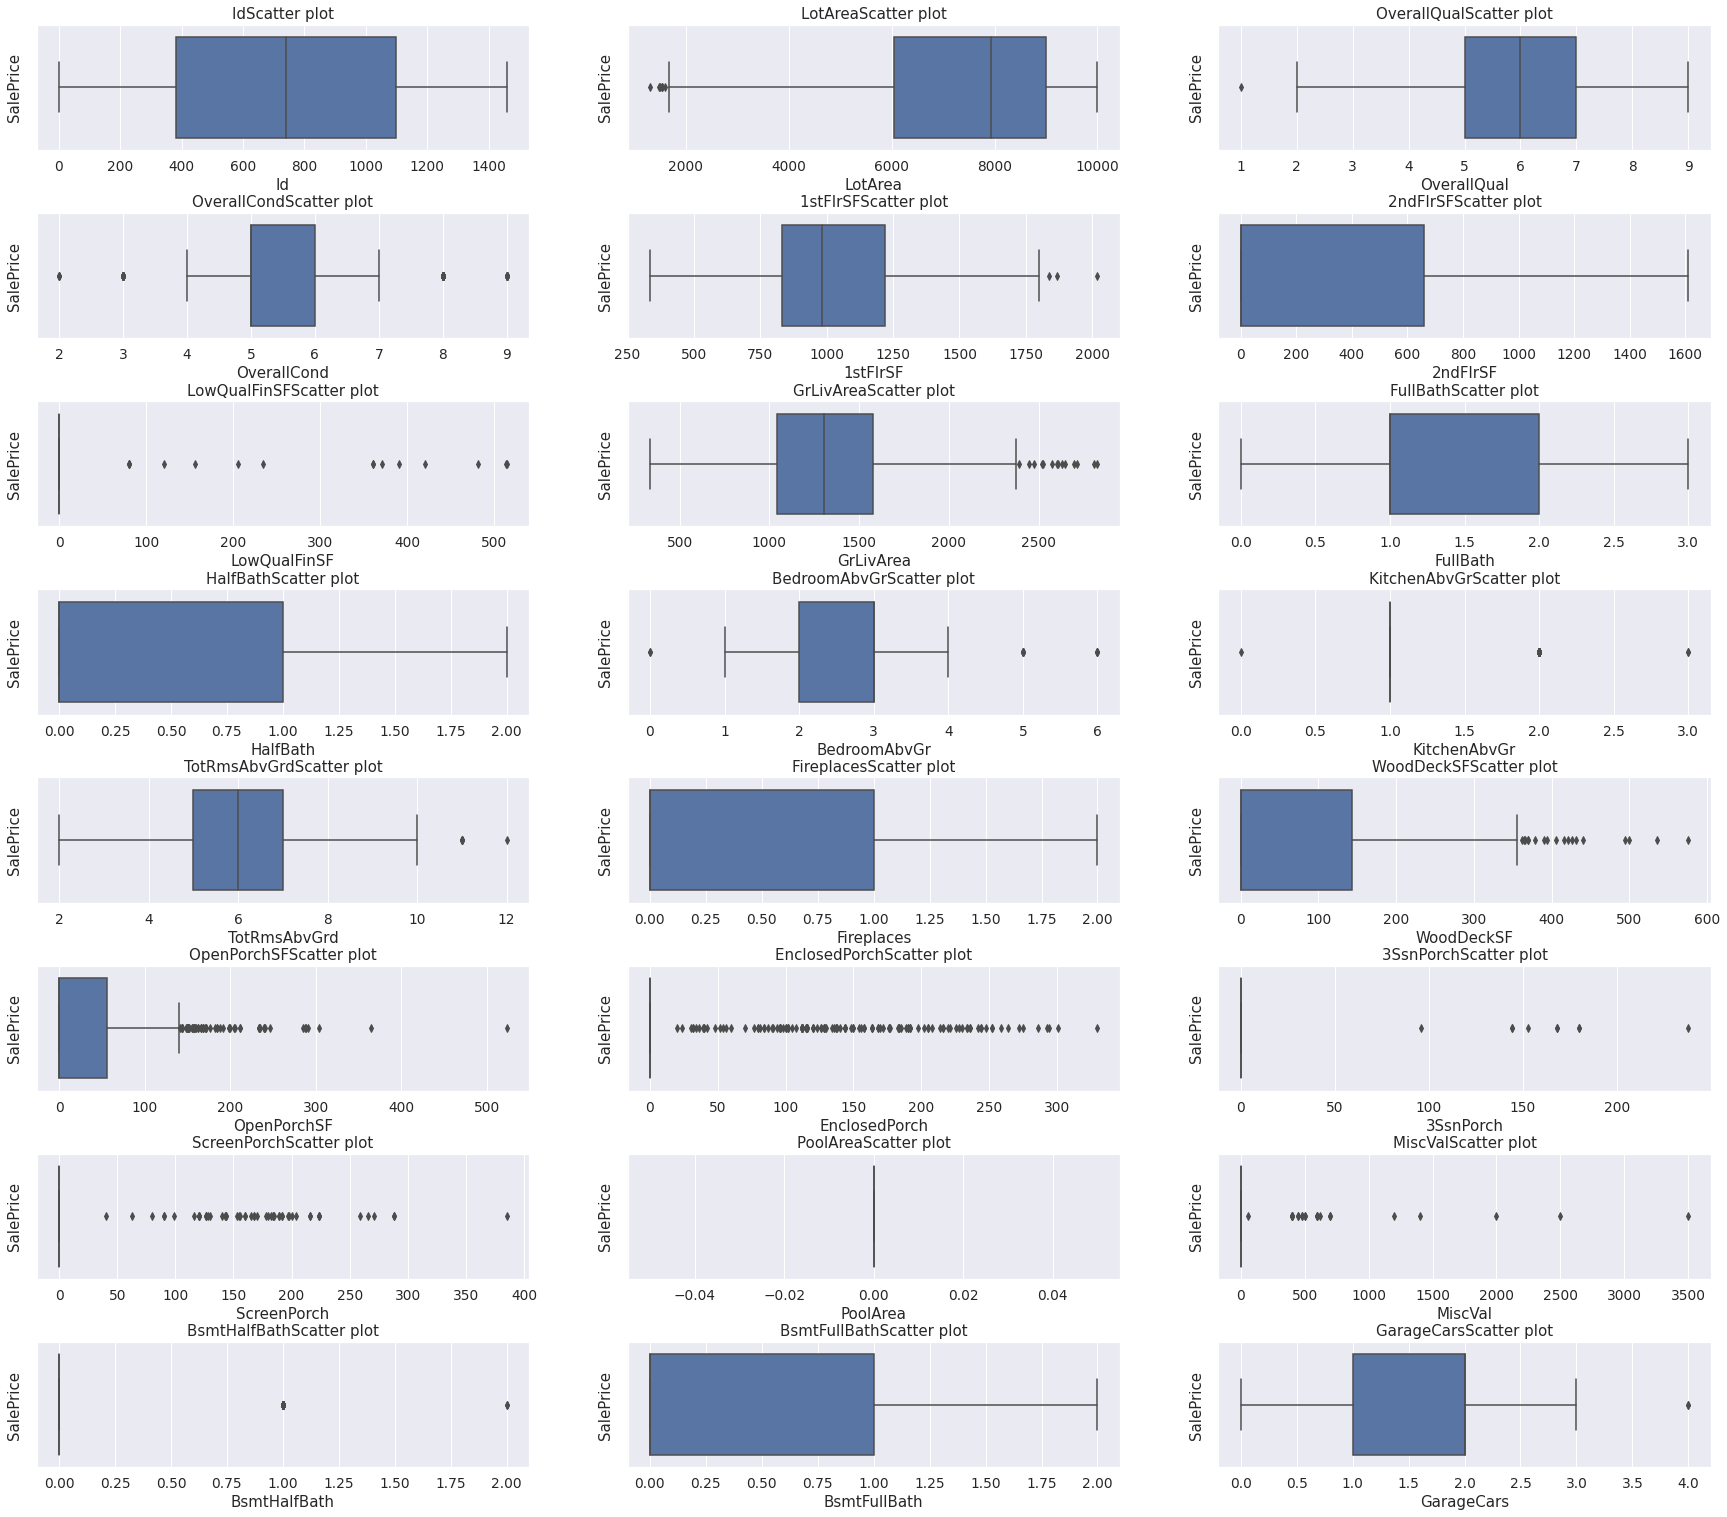

In [140]:
# int colums scatter plot
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.5)
for i, var in enumerate(int_cols):
  plt.subplot(9,3,i+1)
  fig = sns.boxplot(house_df[tr_idx][var])
  fig.set_ylabel("SalePrice", labelpad = 5)
  fig.set_xlabel(var)
  str3= "".join([var,'Scatter plot'])
  fig.set_title(str3)
plt.show()

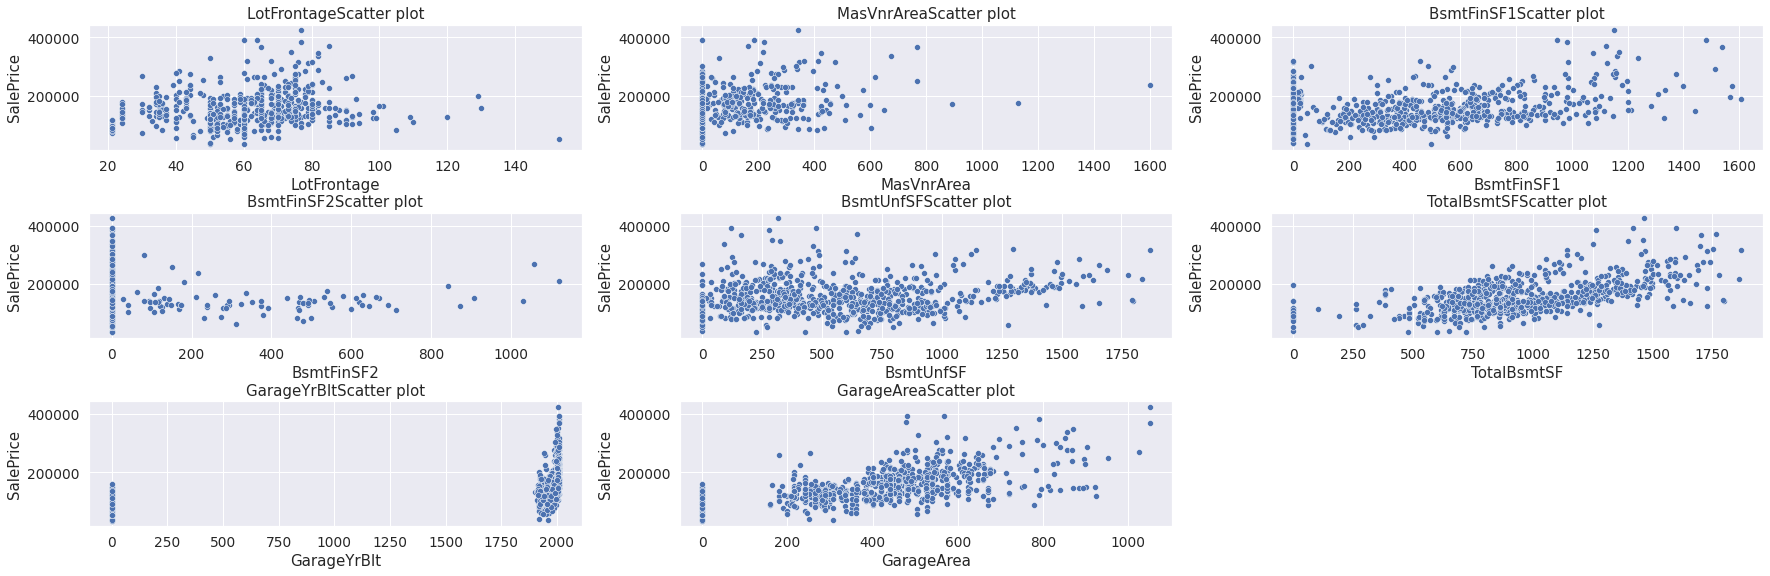

In [141]:
# float colums scatter plot
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.5)
for i, var in enumerate(float_cols):
  plt.subplot(9,3,i+1)
  fig = sns.scatterplot(data=house_df[tr_idx],x=var,y='SalePrice')
  fig.set_ylabel("SalePrice", labelpad = 5)
  fig.set_xlabel(var)
  str3= "".join([var,'Scatter plot'])
  fig.set_title(str3)
plt.show()

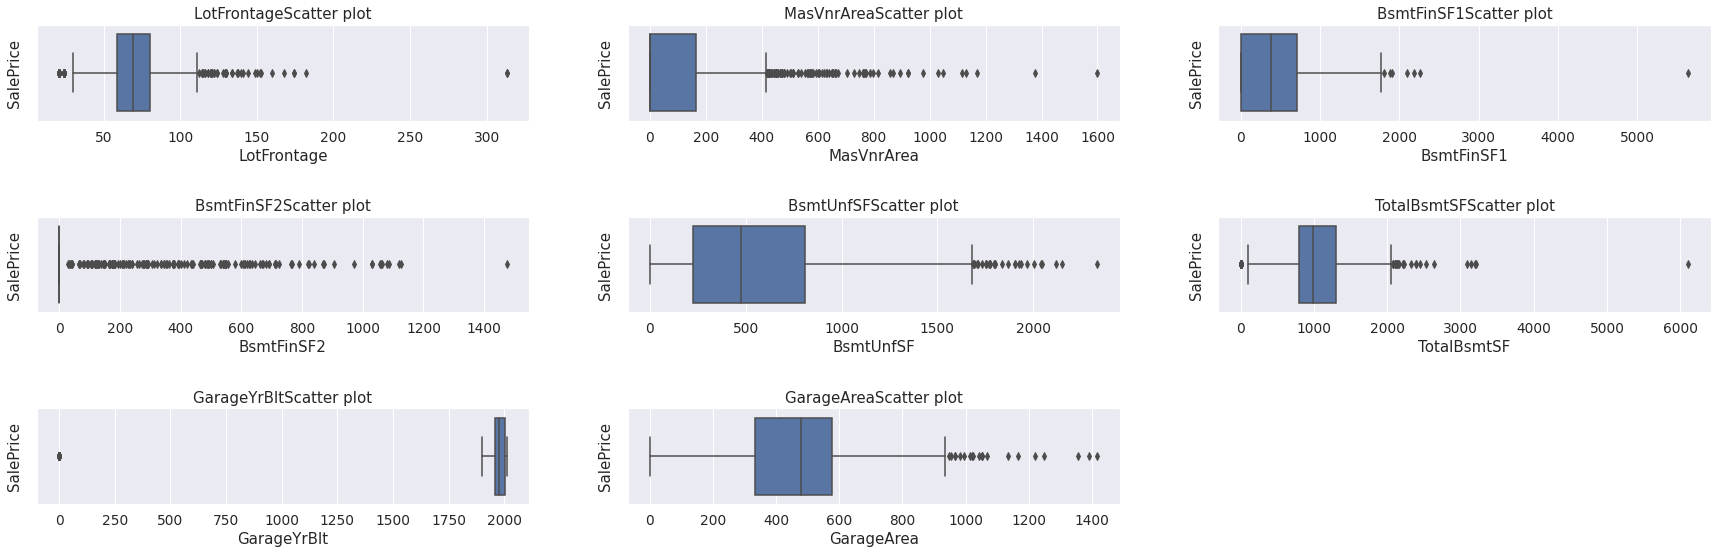

In [142]:
# float colums boxplot
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=1)
for i, var in enumerate(float_cols):
  plt.subplot(9,3,i+1)
  fig = sns.scatterplot(data=train, x=var, y='SalePrice')
  fig = sns.boxplot(train[var])
  fig.set_ylabel("SalePrice", labelpad = 5)
  fig.set_xlabel(var)
  str3= "".join([var,'Scatter plot'])
  fig.set_title(str3)
plt.show()

**For float represented features**:

1. MasVnrArea feature - over 1200
2. BsmtFinSF1 feature - over 2000
3. BsmtFinSF2 feature - over 1200
4. TotalBsmtSF feature - over 3000
5. GarageArea feature - over 1100

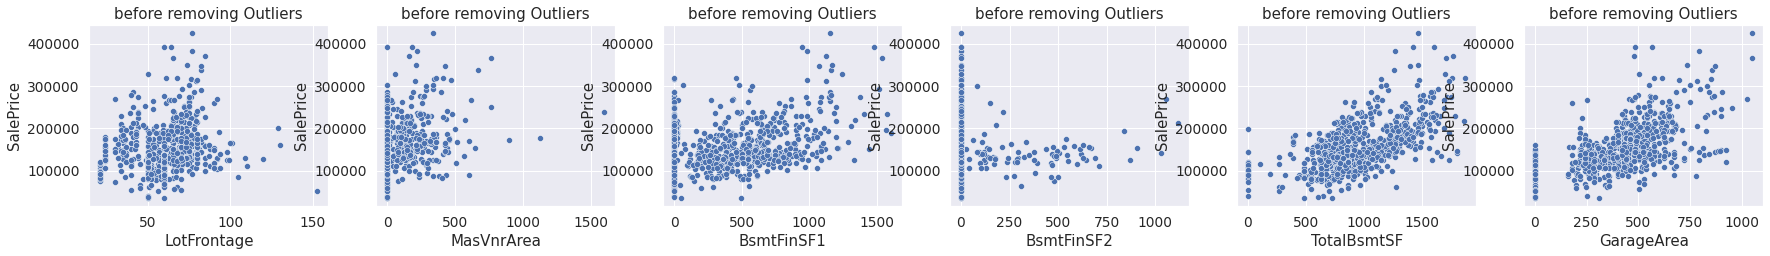

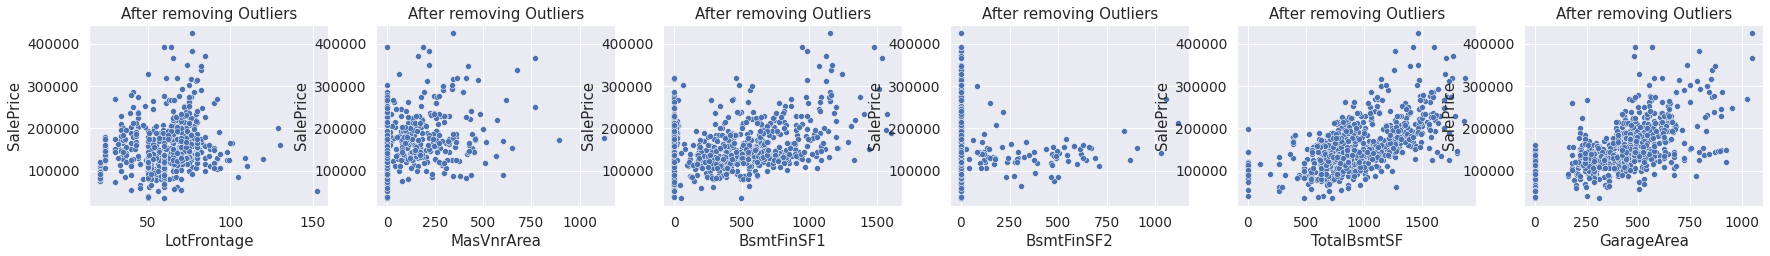

In [143]:
plt.figure(figsize=(30, 10))
plt.subplots_adjust(hspace=1)
float_Outliers = ["LotFrontage","MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "TotalBsmtSF", "GarageArea"]
for i, var in enumerate(float_Outliers):
  plt.subplot(2,len(float_Outliers),i+1)
  fig = sns.scatterplot(data=house_df[tr_idx],x=var,y='SalePrice')
  fig.set_ylabel("SalePrice", labelpad = 5)
  fig.set_xlabel(var)
  fig.set_title("before removing Outliers")
plt.show()

# float cols
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "LotFrontage", 200)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "MasVnrArea", 1200)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "BsmtFinSF1", 2000)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "BsmtFinSF2", 1200)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "TotalBsmtSF", 3000)
house_df[tr_idx] = remove_Outlier(house_df[tr_idx], "GarageArea", 1100)

plt.figure(figsize=(30, 10))
plt.subplots_adjust(hspace=1)
for i, var in enumerate(float_Outliers):
  plt.subplot(2, len(float_Outliers),i + len(float_Outliers) + 1)
  fig = sns.scatterplot(data=house_df[tr_idx],x=var,y='SalePrice')
  fig.set_ylabel("SalePrice", labelpad = 5)
  fig.set_xlabel(var)
  fig.set_title("After removing Outliers")
plt.show()

Distribution shows that, Less number of people who bought the house when the OverallQual is less than 4. So they are not interested for lower quality. Even price looks cheaper people prefer Quality.

Most of the people bought the house between the OverallQual 4 to 8. There is a slight increase in price When quality increase. So money and quality balanced here.

Less number of people who bought the the house when the OverallQual are at top 9 and 10. There is drastic change in price when the quality is at 10. People shows less interest because Price seems too high.

outlier_index = train[(train['OverallQual'] == 4) & (train['SalePrice'] > 200000)].index

 *outlier
We can see OverallQual increases along with SalePrice and the pattern shows that each qual level covers the previous levels completely 
but on index 457(highlighted rectangle) looks different. so we will remove it .

outlier removal
train.drop(outlier_index,axis=0,inplace=True)

When removing outliers according to the int colum, we notice that other outlier has been remove (according to other colums). The reasone behide it is that some samples conation multiple outliers according to different features. This is another reason to throw outlier samples.  

After applying the outliers removal severl times for different features, we notice that the most beneficial removal of outliers contain the following features as described in function: 

1. LotFrontage > 200
2. BsmtFinSF1 > 2000
3. 1stFlrSF > 2500
4. TotalBsmtSF > 3000
5. GrLivArea > 4000
6. LotArea > 100000


In [144]:
def Remove_all_ourliers(data):
  data = remove_Outlier(data, "LotFrontage", 200)
  data = remove_Outlier(data, "BsmtFinSF1", 2000)
  data = remove_Outlier(data, "1stFlrSF", 2500)
  data = remove_Outlier(data, "TotalBsmtSF", 3000)
  data = remove_Outlier(data, "GrLivArea", 4000)
  data = remove_Outlier(data, "LotArea", 100000)
  # idx = ((data["OverallQual"] < 2))
  # index_list = list(data[idx].index)
  # data = data.drop(index_list)
  idx = ((data["OverallQual"] == 4)  & (data['SalePrice'] > 200000))
  index_list = list(data[idx].index)
  data = data.drop(index_list)
  return data

In [145]:
# Creating new train, test and house_df after droping outliers samples
train_rm_o = Remove_all_ourliers(train)
# test_rm_o = Remove_all_ourliers(test)
test_rm_o = test
house_df_rm_o = pd.concat([train_rm_o,test_rm_o],ignore_index = True, sort = False)
tr_idx_rm = house_df_rm_o['SalePrice'].notnull() ## display data with on
te_idx_rm = [not elem for elem in tr_idx]
te_idx_rm = pd.Series(te_idx)

## 2.2 Feature removal

In the database, there are features that missing from samples, we need to treat them correcty. Dropping all the feature with missing values usally not recommended. However, it is ok if most of ths values of the feature are missing. In this section we remove all the feature that most of its values are missing

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py

In [146]:
X_train = house_df_rm_o[tr_idx_rm].drop(['SalePrice'], axis=1)
X_test = house_df_rm_o[te_idx_rm]
Y_train = house_df_rm_o[tr_idx_rm].SalePrice
Y_test = house_df_rm_o[te_idx_rm].SalePrice
overall_X = house_df_rm_o
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(overall_X.shape)

(1442, 80)
(1442,)
(1441, 81)
(1441,)
(2901, 81)


**correlation**:
Relationship between SalePrice and other numerical columns

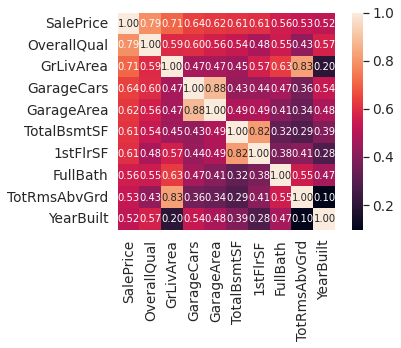

In [147]:
# correlation matrix
corrmat = train.corr()
# f, ax = plt.subplots(figsize=(25, 25))
# # sns.heatmap(corrmat, vmax=.8, square=True);
# hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
# plt.show()

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Most correlated variables according to the dataset description:


* **OverallQual** = Rates the overall material and finish of the house
* **GrLivArea** = Above grade (ground) living area square feet
* **TotalBsmtSF** = Total square feet of basement area
* **GarageCars** = Size of garage in car capacity
* **GarageArea** = Size of garage in square feet
* **TotalBsmtSF** = Total square feet of basement area
* **1stFlrSF** = First Floor square feet
* **FullBath** = Full bathrooms above grade
* **TotRmsAbvGrd** = Total rooms above grade (does not include bathrooms)
* **YearBuilt** = Original construction date

Having the variables with the most correlation with Saleprice we can make the following conlusions:

* **GarageCars** and **GarageArea** are basically the same, de amount of cars will vary on the total size are of the garage, so we can select one of these columns for and drop the other one.
* **TotalBsmtSF** and **1stFlrSF** also looks very similar, we will keep **TotalBsmtSF**
YearBuilt it is wierd how the correlation shows the contruction year not so correlated to the salePrice, some reasons could be the fact that olds hourses might be renovated or located in better areas.
*  **TotRmsAbvGrd** and **GrLivArea** i assume are correlated (0.83) because the total rooms above ground is a big factor 

So, now we can implement feature removal according to 3 factors:

1. **missing_features**: represent the features where most of them missing 

2. **irellvent_features**: represent feature without correlatiuon to the SalePrice

3. **corr_features**: features with high correlation between them 

In [148]:
def featureDrop(data, tr_idx, ifPrint=False, CORR = False):
  missing_features = [col for col in data[tr_idx].columns if (data[tr_idx][col].isnull().sum() / data[tr_idx].shape[0]) * 100 > 50]
  # missing_features.remove("PoolQC")
  irellvent_features = ['Id']
  if CORR:
    # corr_features = ['GarageArea', '1stFlrSF', 'TotRmsAbvGrd']
    # corr_features = ['GarageArea', '1stFlrSF', 'TotRmsAbvGrd']
    corr_features = ['TotRmsAbvGrd']
    # corr_features = ['GarageArea']
    # corr_features = ['1stFlrSF']
    # corr_features = ['TotRmsAbvGrd']
  else:
    corr_features = []
  drop_features = missing_features + irellvent_features + corr_features
  data_drop = data.drop(drop_features, axis=1)
  if ifPrint:
    print('missing_features: {}'.format(missing_features))
    print('irellvent_features: {}'.format(irellvent_features))
  return data_drop

X_df_drop = featureDrop(overall_X, tr_idx, ifPrint=True)
X_train_drop = X_df_drop[tr_idx]
X_test_drop = X_df_drop[te_idx]

print('X_df_drop shape:     {}'.format(X_df_drop.shape))
print('X_train_drop shape:  {}'.format(X_train_drop.shape))
print('X_test_drop shape:   {}'.format(X_test_drop.shape))
print(type(tr_idx))

missing_features: []
irellvent_features: ['Id']
X_df_drop shape:     (2901, 80)
X_train_drop shape:  (1460, 80)
X_test_drop shape:   (1441, 80)
<class 'pandas.core.series.Series'>


Because we removed fetures, the cloums changed:

In [149]:
categorical_cols, int_cols, float_cols = get_colums(X_df_drop)
print("Number of Categorical fetures:",(len(categorical_cols)))
print("Number of integer fetures:",(len(int_cols)))
print("Number of float fetures:",(len(float_cols)))

Number of Categorical fetures: 48
Number of integer fetures: 23
Number of float fetures: 8


## 2.3 Encoding categorical features

#### 2.3.1 Label encoding categorical features

Another option is using Label Encoding which refers to transforming the word labels into numerical form so that the algorithms can understand how to operate on them.

Categorial type features:


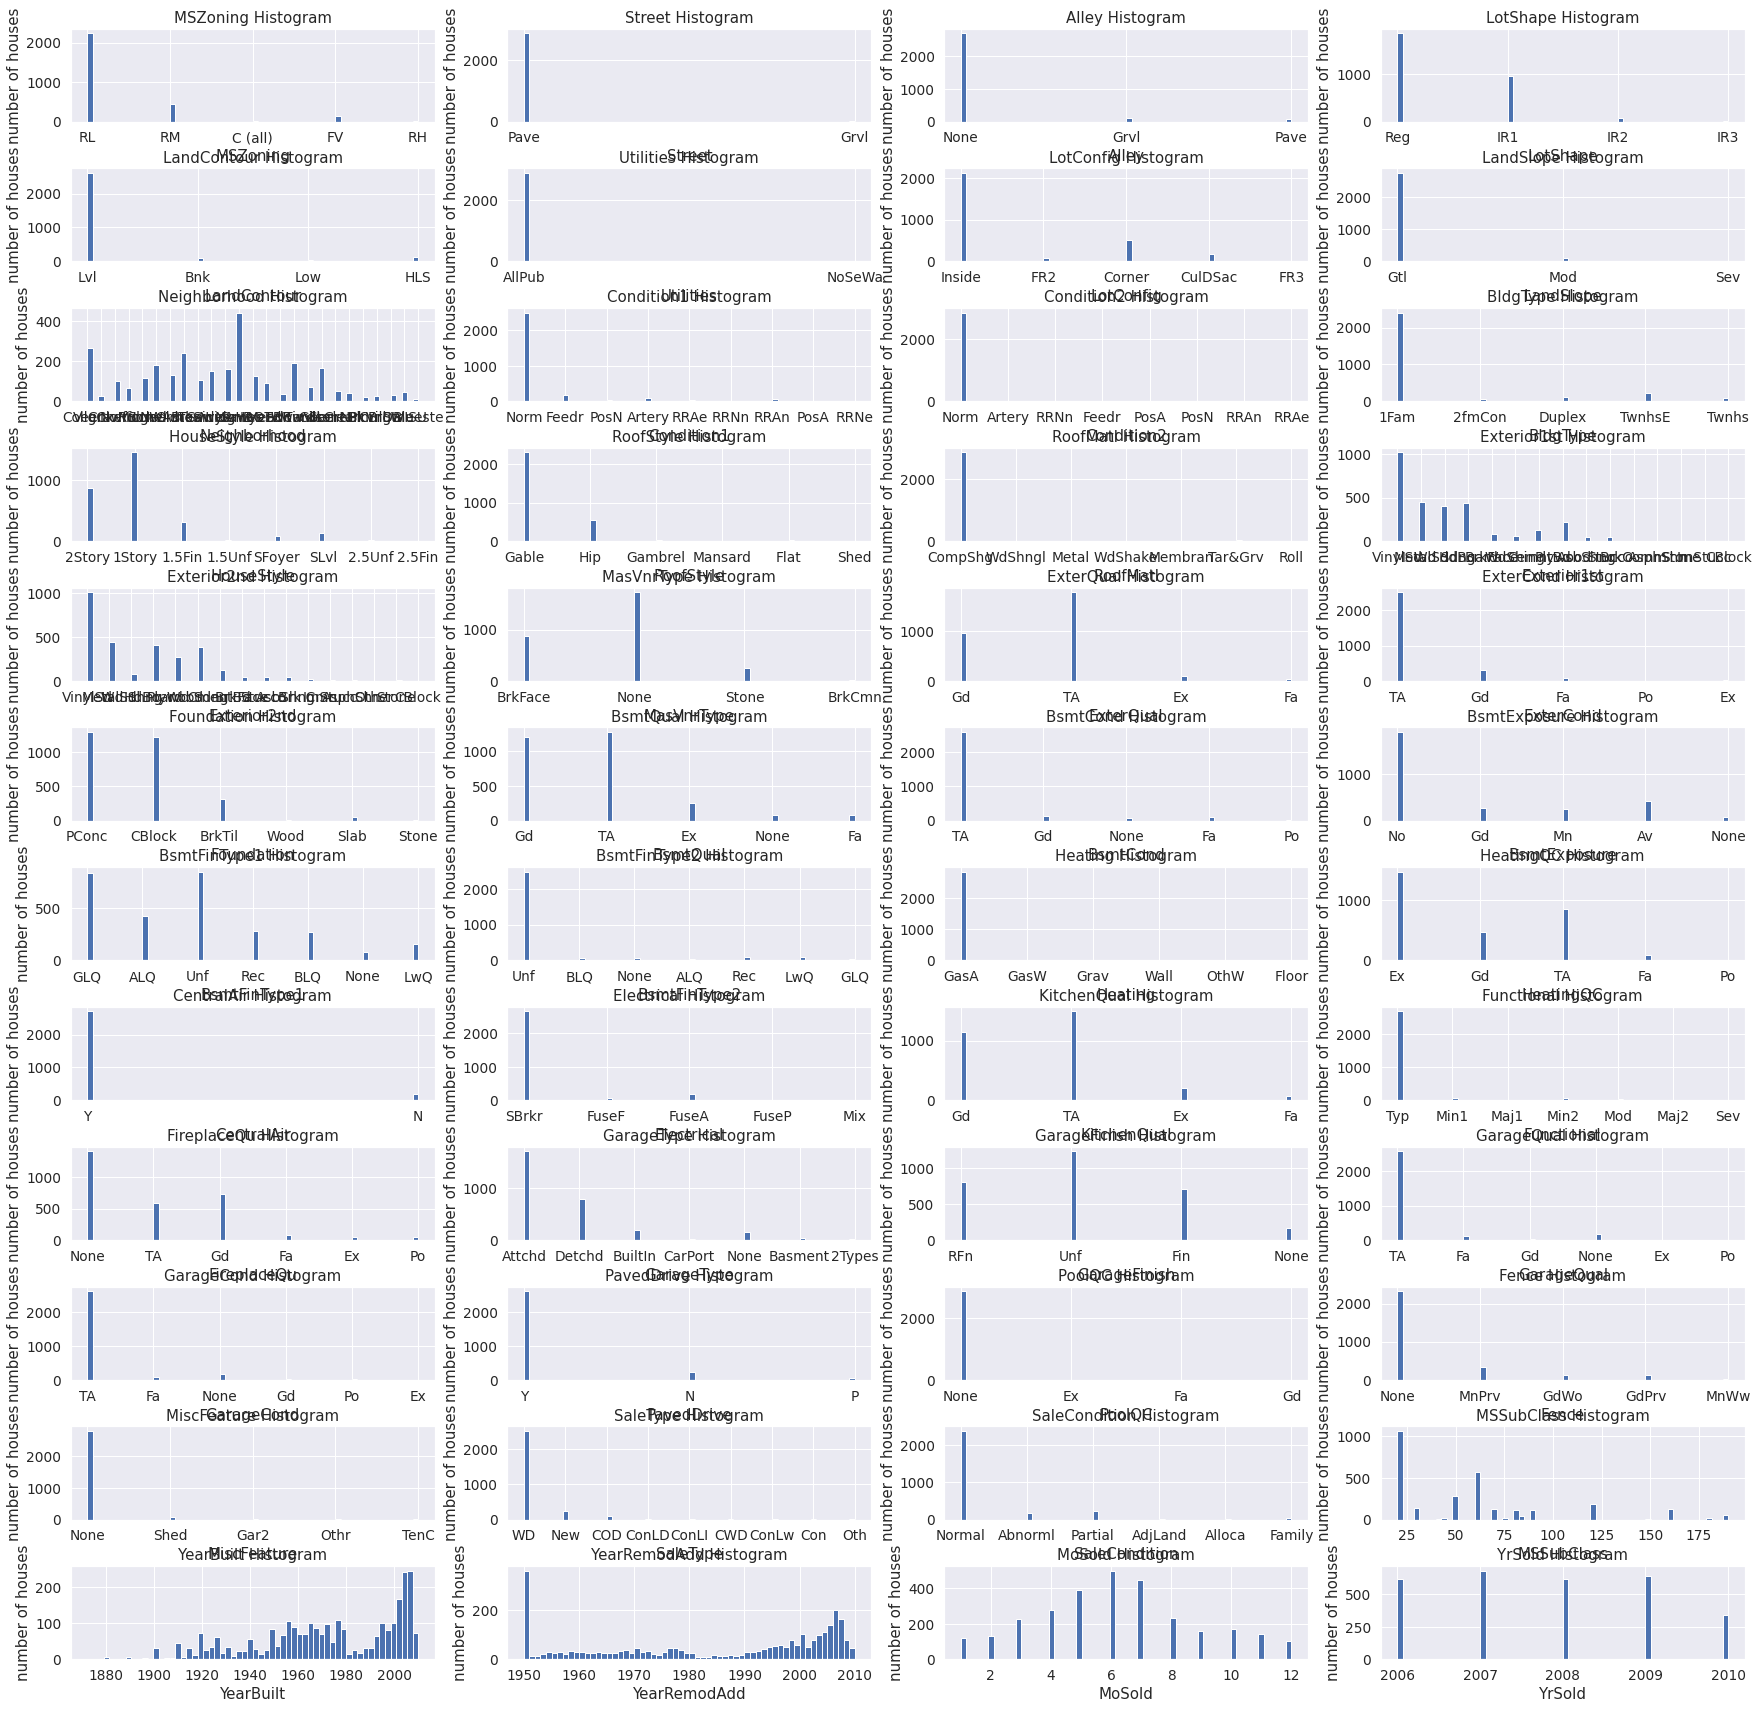

In [152]:
# scatter plot: Categorial type features
print("Categorial type features:")
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.5)
for i, var in enumerate(categorical_cols):
    plt.subplot(12,4,i+1)
    fig = X_df_drop[var].hist(bins=60)
    fig.set_ylabel('number of houses')
    fig.set_xlabel(var)
    str3= "".join([var,' Histogram'])
    fig.set_title(str3)

Categorial type features:


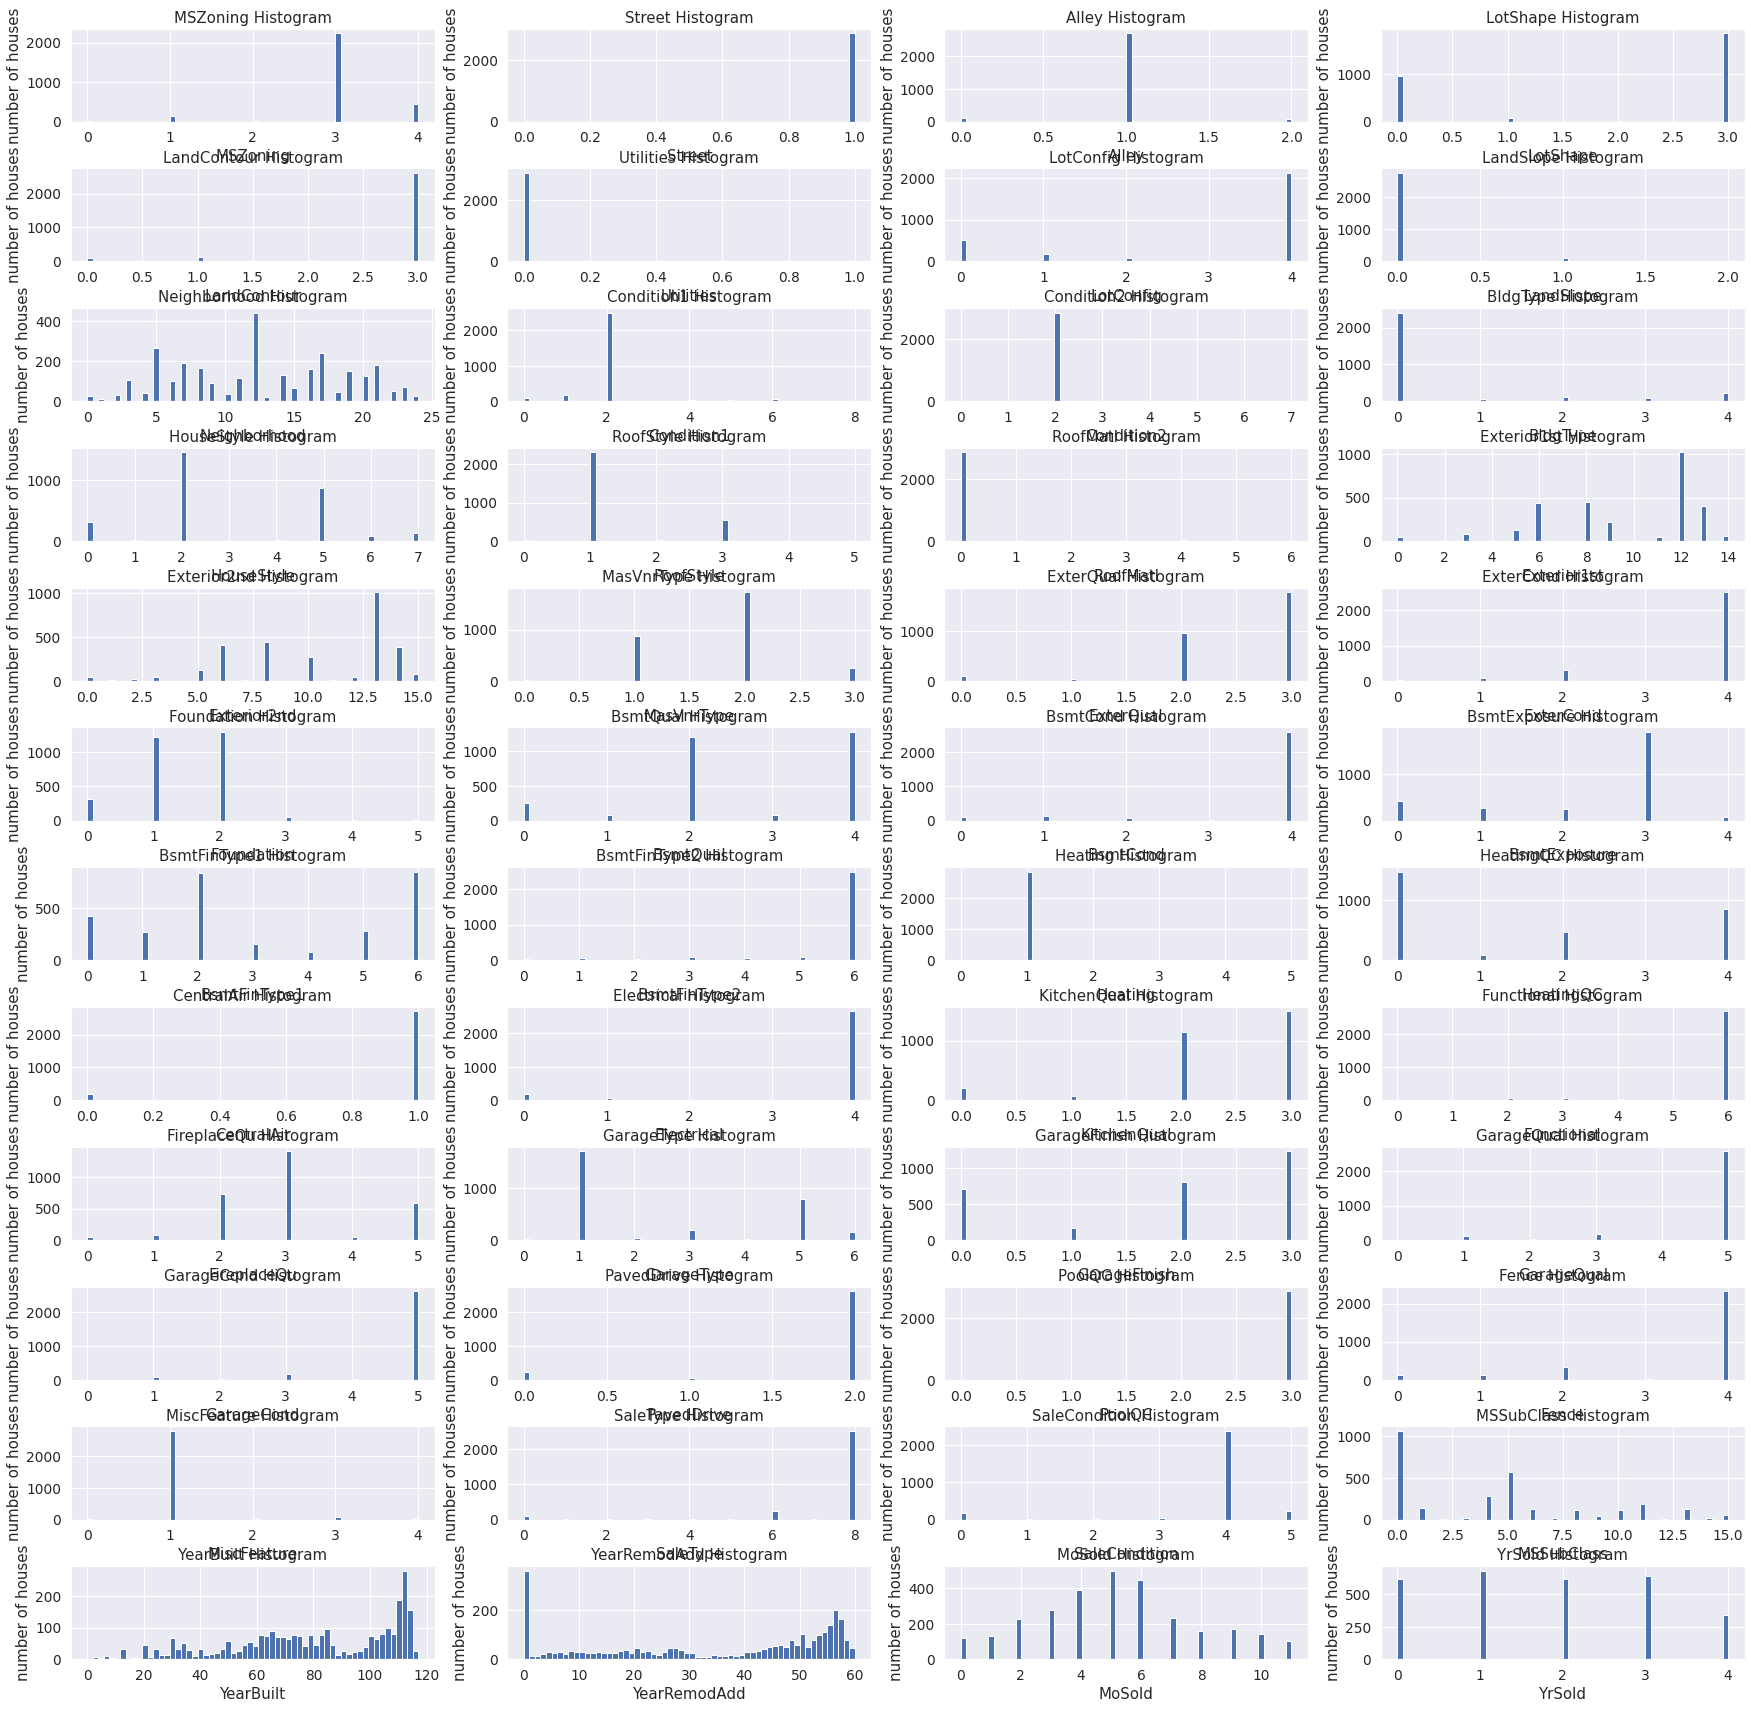

In [154]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


def Labaling_V2(data):
  df = data
  df = df.apply(lambda series: pd.Series(
      LabelEncoder().fit_transform(series[series.notnull()]),
      index=series[series.notnull()].index))
  return df

  
house_df_lab = Labaling_V2(X_df_drop)

print("Categorial type features:")
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.5)
for i, var in enumerate(categorical_cols):
    plt.subplot(12,4,i+1)
    fig = house_df_lab[var].hist(bins=60)
    fig.set_ylabel('number of houses')
    fig.set_xlabel(var)
    str3= "".join([var,' Histogram'])
    fig.set_title(str3)



#### 2.3.2 Factorizing categorical features

Categorial type features:


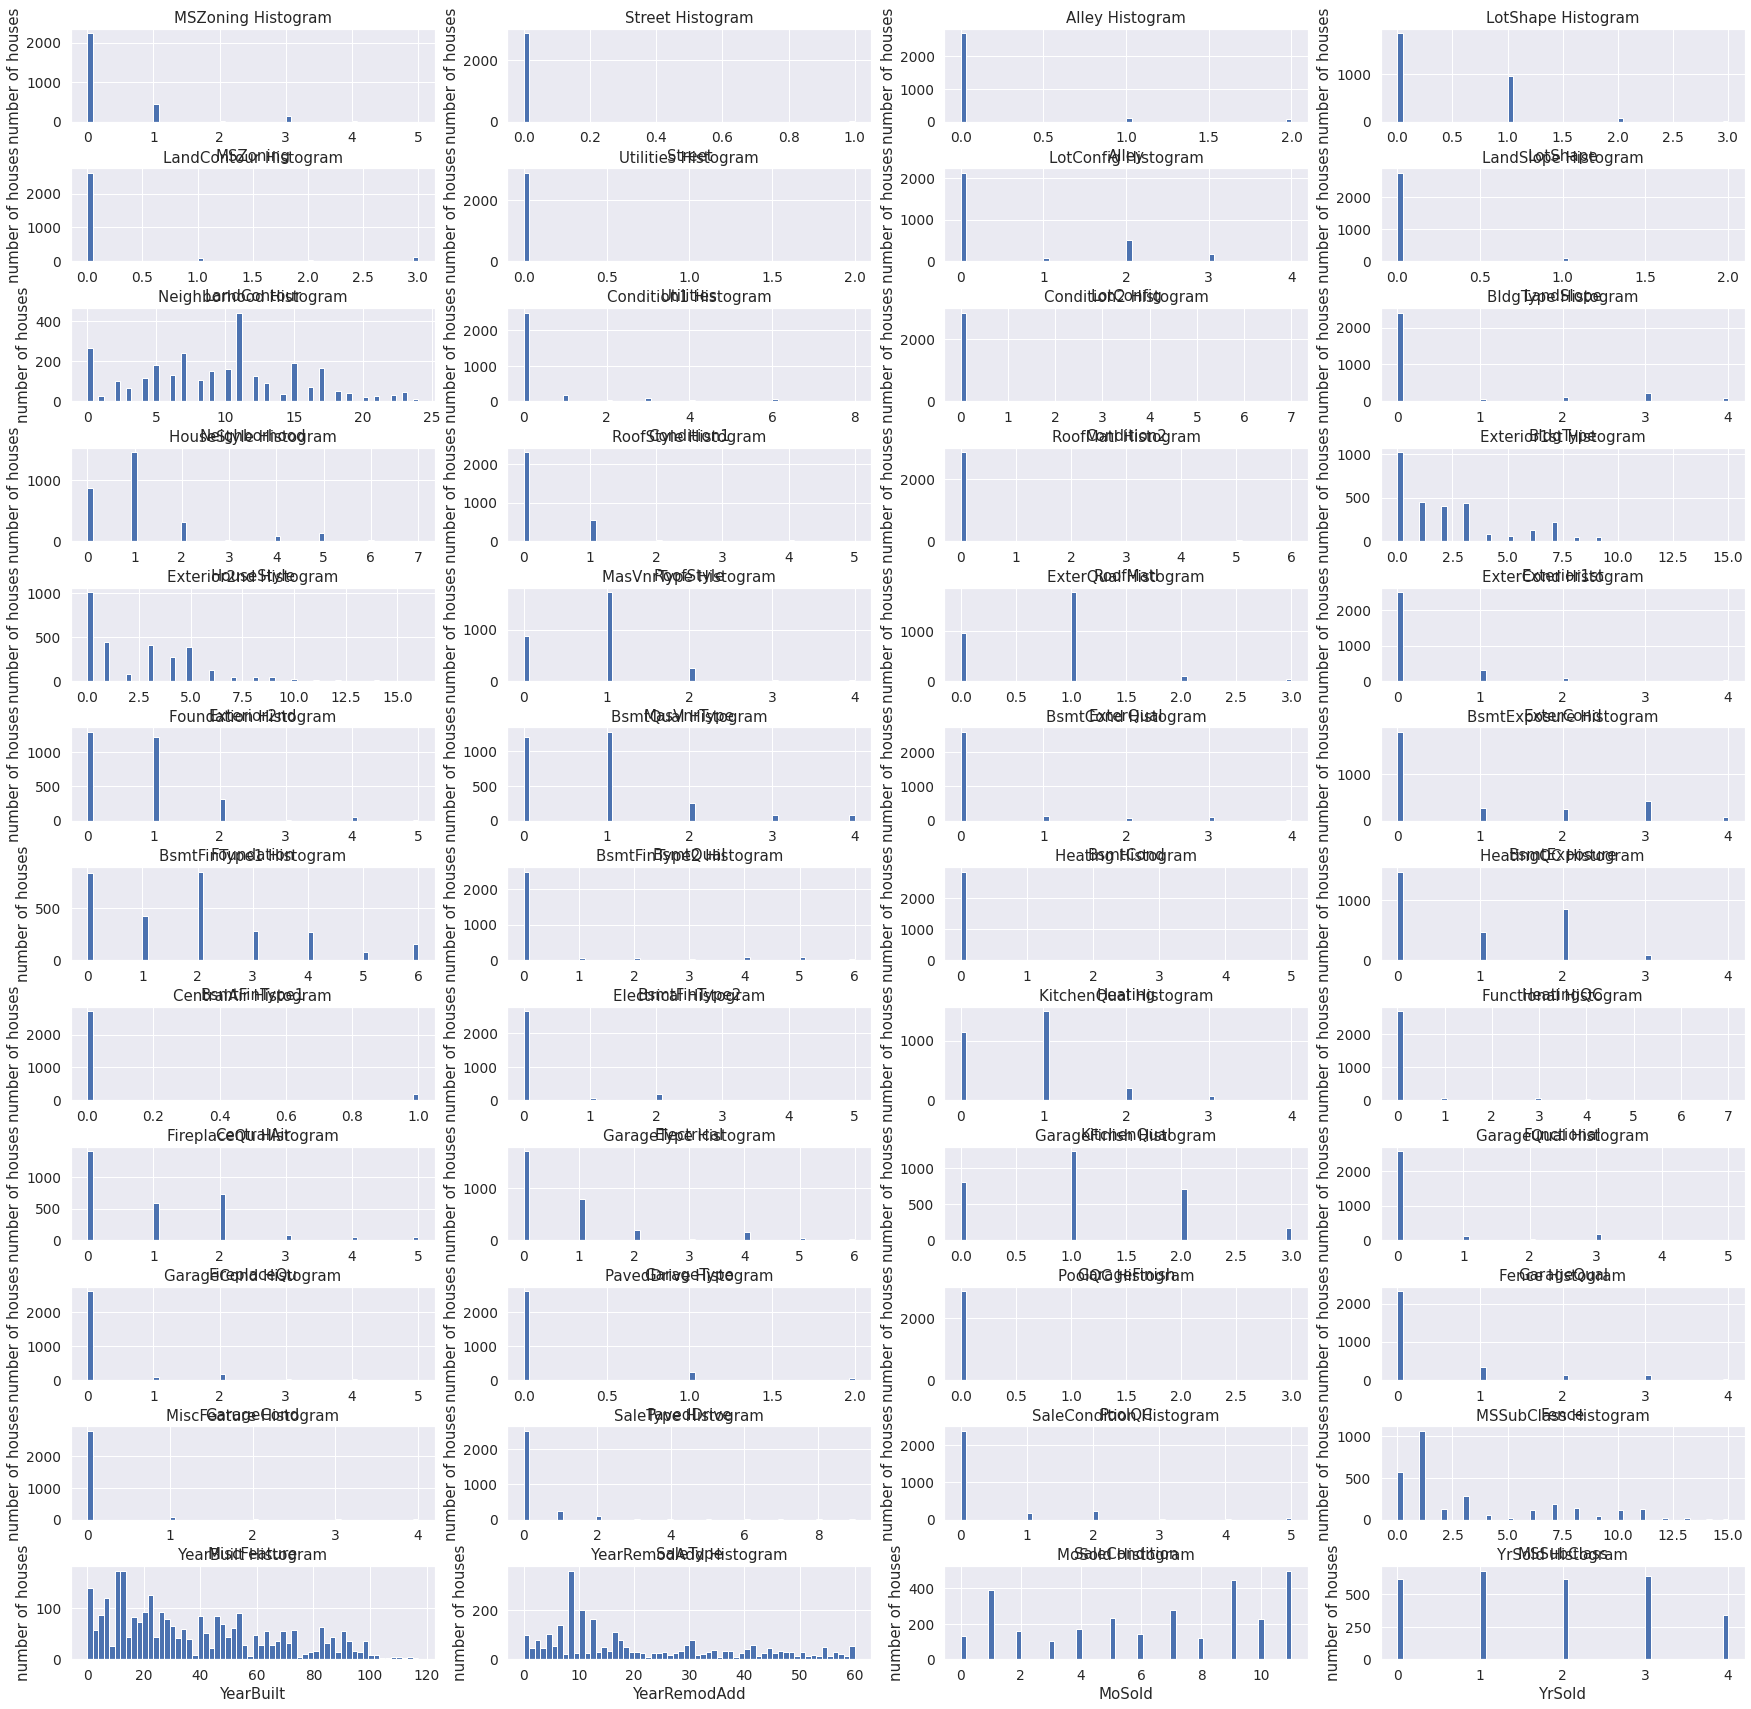

In [156]:
def factorization(data, categorical_cols):
  for c in categorical_cols:
    data[c] = pd.factorize(data[c])[0]
  return data

house_df_fac = X_df_drop
house_df_fac = factorization(house_df_fac, categorical_cols)

print("Categorial type features:")
plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.5)
for i, var in enumerate(categorical_cols):
    plt.subplot(12,4,i+1)
    fig = X_df_drop[var].hist(bins=60)
    fig.set_ylabel('number of houses')
    fig.set_xlabel(var)
    str3= "".join([var,' Histogram'])
    fig.set_title(str3)

#### 2.3.3 One-hot encoding categorical features
We apply One-Hot Encoding when:

The categorical feature is not ordinal (like the countries above)
The number of categorical features is less so one-hot encoding can be effectively applied
We apply Label Encoding when:

The categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school)
 The number of categories is quite large as one-hot encoding can lead to high memory consumption

In [157]:
"""
pd.set_option('display.max_rows', None)
missing_data = pd.DataFrame(df.isna().sum())
missing_data_prec = missing_data/df.shape[0] * 100
missing_data = pd.concat([missing_data,missing_data_prec], axis=1)
missing_data.columns =['occurence', 'precentage']
print(missing_data)
pd.reset_option('all')
"""

"\npd.set_option('display.max_rows', None)\nmissing_data = pd.DataFrame(df.isna().sum())\nmissing_data_prec = missing_data/df.shape[0] * 100\nmissing_data = pd.concat([missing_data,missing_data_prec], axis=1)\nmissing_data.columns =['occurence', 'precentage']\nprint(missing_data)\npd.reset_option('all')\n"

## 2.4 Replacing missing values

### 2.4.1 Categorical colums: replacing with statistical value

In [158]:
X = house_df_lab
pd.set_option('display.max_rows', None)
missing_data = pd.DataFrame(X.isna().sum())
missing_data_prec = missing_data/X.shape[0] * 100
missing_data = pd.concat([missing_data,missing_data_prec], axis=1)
missing_data.columns =['occurence', 'precentage']
print(missing_data)
pd.reset_option('all')

               occurence  precentage
MSSubClass             0    0.000000
MSZoning               4    0.137883
LotFrontage          478   16.477077
LotArea                0    0.000000
Street                 0    0.000000
Alley                  0    0.000000
LotShape               0    0.000000
LandContour            0    0.000000
Utilities              2    0.068942
LotConfig              0    0.000000
LandSlope              0    0.000000
Neighborhood           0    0.000000
Condition1             0    0.000000
Condition2             0    0.000000
BldgType               0    0.000000
HouseStyle             0    0.000000
OverallQual            0    0.000000
OverallCond            0    0.000000
YearBuilt              0    0.000000
YearRemodAdd           0    0.000000
RoofStyle              0    0.000000
RoofMatl               0    0.000000
Exterior1st            1    0.034471
Exterior2nd            1    0.034471
MasVnrType            23    0.792830
MasVnrArea            22    0.758359
E

we should try to apply the missing values algorithms for the concatanate data, and on the train data by itself.

In [159]:
from sklearn.impute import SimpleImputer, KNNImputer
class Impute_class(object):
  def __init__(self, X):
    self.X = X

  def impute_values(self, cols, method, K = 2):
    data = self.X
    self.method = method
    self.K = K
    imputer = self.impute_method()
    imputer.fit(self.X)
    new_X = pd.DataFrame(imputer.fit_transform(self.X[cols]))
    new_X.cols = self.X[cols].columns
    data[cols] = new_X
    return data

  def impute_method(self):
    if self.method == "zero":
      imputer = SimpleImputer(add_indicator=False, strategy="constant", fill_value=0)

    elif self.method == "mean":
      imputer = SimpleImputer(add_indicator=False, strategy="mean")

    elif self.method == "median":
      imputer = SimpleImputer(add_indicator=False, strategy="median")
      
    elif self.method == "most_frequent":
      imputer = SimpleImputer(add_indicator=False, strategy="most_frequent")

    elif self.method == "KNN":
      imputer = KNNImputer(n_neighbors=self.K, weights="uniform")
      
    return imputer

In [160]:
I = Impute_class(X=house_df_lab)
I.impute_values(cols=categorical_cols, method= "median")
X = I.X

In [161]:
pd.set_option('display.max_rows', None)
missing_data = pd.DataFrame(X.isna().sum())
missing_data_prec = missing_data/X.shape[0] * 100
missing_data = pd.concat([missing_data,missing_data_prec], axis=1)
missing_data.columns =['occurence', 'precentage']
print(missing_data)
pd.reset_option('all')

               occurence  precentage
MSSubClass             0    0.000000
MSZoning               0    0.000000
LotFrontage          478   16.477077
LotArea                0    0.000000
Street                 0    0.000000
Alley                  0    0.000000
LotShape               0    0.000000
LandContour            0    0.000000
Utilities              0    0.000000
LotConfig              0    0.000000
LandSlope              0    0.000000
Neighborhood           0    0.000000
Condition1             0    0.000000
Condition2             0    0.000000
BldgType               0    0.000000
HouseStyle             0    0.000000
OverallQual            0    0.000000
OverallCond            0    0.000000
YearBuilt              0    0.000000
YearRemodAdd           0    0.000000
RoofStyle              0    0.000000
RoofMatl               0    0.000000
Exterior1st            0    0.000000
Exterior2nd            0    0.000000
MasVnrType             0    0.000000
MasVnrArea            22    0.758359
E

In [ ]:
"""
I = Impute_class(X=X)
# I.impute_values(cols=categorical_cols, method= "most_frequent")
I.impute_values(cols= int_cols, method= "median")
I.impute_values(cols= float_cols, method= "KNN", K=10)
X = I.X

pd.set_option('display.max_rows', None)
missing_data = pd.DataFrame(X.isna().sum())
missing_data_prec = missing_data/X.shape[0] * 100
missing_data = pd.concat([missing_data,missing_data_prec], axis=1)
missing_data.columns =['occurence', 'precentage']
print(missing_data)
pd.reset_option('all')
"""

### 2.4.2 Missing Values - int and float colums

In [162]:
I = Impute_class(X=X)
# I.impute_values(cols=categorical_cols, method= "most_frequent")
I.impute_values(cols= int_cols, method= "median")
I.impute_values(cols= float_cols, method= "KNN", K=10)
X = I.X

pd.set_option('display.max_rows', None)
missing_data = pd.DataFrame(X.isna().sum())
missing_data_prec = missing_data/X.shape[0] * 100
missing_data = pd.concat([missing_data,missing_data_prec], axis=1)
missing_data.columns =['occurence', 'precentage']
print(missing_data)
pd.reset_option('all')

               occurence  precentage
MSSubClass             0    0.000000
MSZoning               0    0.000000
LotFrontage            0    0.000000
LotArea                0    0.000000
Street                 0    0.000000
Alley                  0    0.000000
LotShape               0    0.000000
LandContour            0    0.000000
Utilities              0    0.000000
LotConfig              0    0.000000
LandSlope              0    0.000000
Neighborhood           0    0.000000
Condition1             0    0.000000
Condition2             0    0.000000
BldgType               0    0.000000
HouseStyle             0    0.000000
OverallQual            0    0.000000
OverallCond            0    0.000000
YearBuilt              0    0.000000
YearRemodAdd           0    0.000000
RoofStyle              0    0.000000
RoofMatl               0    0.000000
Exterior1st            0    0.000000
Exterior2nd            0    0.000000
MasVnrType             0    0.000000
MasVnrArea             0    0.000000
E

## 2.5 Taking care of skewed target

The Sale price is a bit skewed, and for linear models its important that you normalize your data, so im going to log transform it

In [163]:
house_df_X = X
house_df_X
train_X = house_df_X[tr_idx_rm]
test_X = house_df_X[te_idx_rm]

In [164]:
Y_price = house_df_rm_o[tr_idx_rm].SalePrice
Y_price

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1437    175000.0
1438    210000.0
1439    266500.0
1440    142125.0
1441    147500.0
Name: SalePrice, Length: 1442, dtype: float64

Text(0.5, 1.0, 'Log Transform Target SalePrice - unskewed')

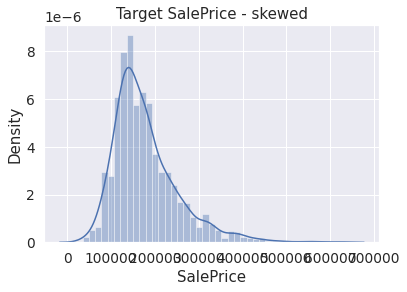

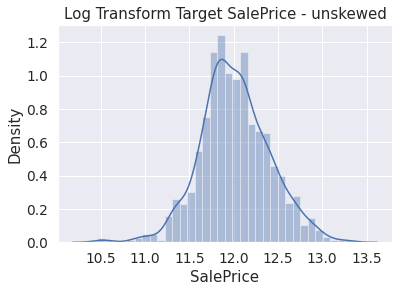

In [165]:
plt.figure()
sns.distplot(Y_price);
Y_price_log = np.log1p(Y_price)
plt.title('Target SalePrice - skewed')
plt.figure()
sns.distplot(Y_price_log)
plt.title('Log Transform Target SalePrice - unskewed')



##2.6 Normalize features

https://www.width.ai/pandas/normalize-column-pandas-dataframe

There is a problem here since all elements became float type - its sh

In [166]:
from scipy import stats
house_df_X_norm = pd.DataFrame(stats.zscore(house_df_X))
house_df_X_norm.columns = house_df_X.columns

# Section 3: Implement prediction models

## 3.1 Model implemention and evaluation

In [167]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

class Regression_model(object):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def Linear_reg(self):
        self.model = LinearRegression(normalize=True)
        self.model.fit(self.X, self.Y)

    def Lasso_reg(self, alphas):
        self.model = LassoCV(alphas=alphas)
        self.model.fit(self.X, self.Y)
        
    def Ridge_reg(self, alpha):
        self.model = Ridge(alpha)
        self.model.fit(self.X, self.Y)

    def KernelRidge_reg(self, alpha):
        self.model = KernelRidge(alpha)
        self.model.fit(self.X, self.Y)

    def RidgeKfold_reg(self, alphas):
        # should enter a list of alphas - algorithem uses the most beneficial
        # alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1] 
        self.model = RidgeCV(alphas)
        self.model.fit(self.X, self.Y)

    def Poly_reg(self):
        self.model = PolynomialFeatures(interaction_only=True)
        self.model.fit(self.X, self.Y)

    def score_dataset(self, X_test, y_test, ifPrint=True):
        preds = self.model.predict(X_test)
        MAE = mean_absolute_error(y_test, preds)
        R2 = r2_score(y_test,y_pred=preds)
        RMSE = np.sqrt(mean_squared_error(y_test,y_pred=preds))
        # Score = self.model.score(X_test, y_test)
        if ifPrint:
          print("MAE = {}".format(MAE))
          print("R2 = {}".format(R2))
          print("RMSE = {}".format(RMSE))
        # print("Score = {}".format(Score))
        return MAE, R2, RMSE


In [168]:
def evaluate_model(data_train, data_valid, target_train, target_valid, ifPrint=True):
  MAE_array_train = []
  MAE_array_valid = []
  R2_array_train = []
  R2_array_valid = []
  RMSE_array_train = []
  RMSE_array_valid = []


  if ifPrint: print("Linear Regression Model results:")
  R = Regression_model(Xtrain, ytrain)
  R.Linear_reg()
  if ifPrint: print("performences over Train set:")
  Score = R.score_dataset(Xtrain, ytrain, ifPrint)
  MAE_array_train.append(Score[0])
  R2_array_train.append(Score[1])
  RMSE_array_train.append(Score[2])
  
  
  if ifPrint: print("\n")

  if ifPrint: print("performences over Validation set:")
  Score = R.score_dataset(Xvalid, yvalid, ifPrint)
  MAE_array_valid.append(Score[0])
  R2_array_valid.append(Score[1])
  RMSE_array_valid.append(Score[2])
  if ifPrint: print("\n")

  if ifPrint: print("Lasso Regression Model results:")
  R.Lasso_reg([1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
  if ifPrint: print("performences over Train set:")
  Score = R.score_dataset(Xtrain, ytrain, ifPrint)
  MAE_array_train.append(Score[0])
  R2_array_train.append(Score[1])
  RMSE_array_train.append(Score[2])
  if ifPrint: print("\n")

  if ifPrint: print("performences over Validation set:")
  Score = R.score_dataset(Xvalid, yvalid, ifPrint)
  MAE_array_valid.append(Score[0])
  R2_array_valid.append(Score[1])
  RMSE_array_valid.append(Score[2])
  if ifPrint: print("\n")

  # print("Kernal Ridge Regression Model results:")
  # K_reg = R.KernelRidge_reg(10)
  # print("performences over Train set:")
  # R.score_dataset(Xtrain, ytrain)
  # print("\n")
  # print("performences over Validation set:")
  # R.score_dataset(Xvalid, yvalid)
  # print("\n")

  R.RidgeKfold_reg([1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
  if ifPrint: print("Ridge Kfold Regression Model results:")
  if ifPrint: print("performences over Train set:")
  Score = R.score_dataset(Xtrain, ytrain, ifPrint)
  MAE_array_train.append(Score[0])
  R2_array_train.append(Score[1])
  RMSE_array_train.append(Score[2])
  if ifPrint: print("\n")

  if ifPrint: print("performences over Validation set:")
  Score = R.score_dataset(Xvalid, yvalid, ifPrint)
  MAE_array_valid.append(Score[0])
  R2_array_valid.append(Score[1])
  RMSE_array_valid.append(Score[2])
  if ifPrint: print("\n")

  if ifPrint:
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
    axs[0].scatter(["Linear", "Lasso", "Ridge"], MAE_array_valid)
    axs[1].scatter(["Linear", "Lasso", "Ridge"], R2_array_valid)
    axs[2].scatter(["Linear", "Lasso", "Ridge"], RMSE_array_valid)
    axs[0].set_ylabel("MAE")
    axs[1].set_ylabel("R2")
    axs[2].set_ylabel("RMSE")
    axs[0].set_xlabel("Regression method")
    axs[1].set_xlabel("Regression method")
    axs[2].set_xlabel("Regression method")
    fig.suptitle('Regression methods validation Performences')
    plt.show()
  return MAE_array_valid, R2_array_valid, RMSE_array_valid

## 3.2 Test current model

### 3.2.1 Data Split

Splitting the original train data into train and validation 

consider use k-fold

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = house_df_X.drop(['SalePrice'], axis=1)
Y_train = Y_price_log
X_train = X[tr_idx_rm]
X_test = [te_idx_rm]


print(X.shape)
print(Y_train.shape)
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 0)
print("Xtrain : " + str(Xtrain.shape))
print("Xtest : " + str(Xvalid.shape))
print("ytrain : " + str(ytrain.shape))
print("ytest : " + str(yvalid.shape))

(2901, 79)
(1442,)
Xtrain : (1009, 79)
Xtest : (433, 79)
ytrain : (1009,)
ytest : (433,)


https://www.bmc.com/blogs/mean-squared-error-r2-and-variance-in-regression-analysis/

### 3.2.2 Evaluate models

Linear Regression Model results:
performences over Train set:
MAE = 0.07955957326248751
R2 = 0.9206835616280614
RMSE = 0.1101611417511812


performences over Validation set:
MAE = 0.09284199422468241
R2 = 0.8897361911687055
RMSE = 0.1297461492058426


Lasso Regression Model results:
performences over Train set:
MAE = 0.08098821563053965
R2 = 0.9178632495637153
RMSE = 0.112102574034803


performences over Validation set:
MAE = 0.09088398644896677
R2 = 0.8932616336754604
RMSE = 0.12765512573867396


Ridge Kfold Regression Model results:
performences over Train set:
MAE = 0.08016510939759451
R2 = 0.9196673039244805
RMSE = 0.11086462635122692


performences over Validation set:
MAE = 0.09278474324557659
R2 = 0.8902203045310549
RMSE = 0.12946101058763884




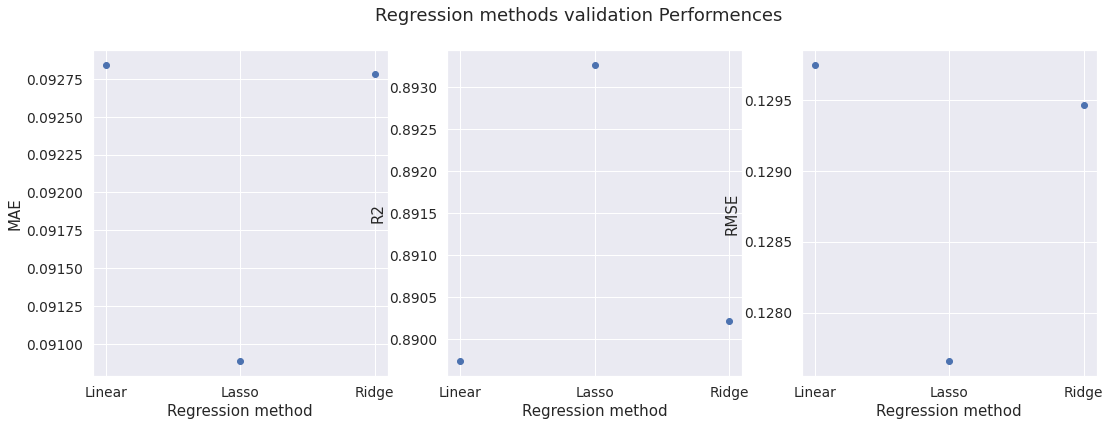

([0.09284199422468241, 0.09088398644896677, 0.09278474324557659],
 [0.8897361911687055, 0.8932616336754604, 0.8902203045310549],
 [0.1297461492058426, 0.12765512573867396, 0.12946101058763884])

In [170]:
evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=True)

Playing with the KNN imputation - will take onlr Ridge and Lasso regression



## 3.3 initialization function

Now, we will generelize all the Feature engineering we implemented to 'initialize_data' function in order to test different hyperparameters

In [261]:
# Amit initialize function
import numpy as np
import pandas as pd
from scipy import stats

# param for later: impCat, impInt, impFloat, kCat = 10, kInt = 10, kFloat = 10
def initialize_data(impCat, impInt, impFloat, catEnc = 'Factorazie', K_val=10, NORMALIZE=False,CORR=False ):
    train = pd.read_csv(main_path + '/train.csv')
    test = pd.read_csv(main_path + '/test.csv')
    
    # missing values
    train = Fmissing_featuers(train)
    test = Fmissing_featuers(test)

    # remova outliers
    train = Remove_all_ourliers(train)

    # indexing
    house_df = pd.concat([train,test],ignore_index = True, sort = False)
    tr_idx = house_df['SalePrice'].notnull()
    te_idx = [not elem for elem in tr_idx]
    te_idx = pd.Series(te_idx)

    X_train = house_df[tr_idx].drop(['SalePrice'], axis=1)
    # X_test = house_df[te_idx].drop(['SalePrice'], axis=1)


    ## missing features - remove features 
    X_df_drop = featureDrop(house_df, tr_idx, ifPrint=False,CORR = CORR)
    X_train_drop = X_df_drop[tr_idx]
    X_test_drop = X_df_drop[te_idx]
    Y_price = X_df_drop.SalePrice

    #colums
    categorical_cols, int_cols, float_cols = get_colums(X_df_drop, change_col=True)

    ## Categorical encoding
    if catEnc == 'Label':
      X_df_encode = Labaling_V2(X_df_drop)
    elif catEnc == 'Factorazie':
      X_df_encode = factorization(X_df_drop,categorical_cols)

    ## missing features - impute features
    I = Impute_class(X=X_df_encode)
    # categorical features
    if impCat == "KNN":
      I.impute_values(cols=categorical_cols, method= impCat, K=K_val)
    else: 
      I.impute_values(cols=categorical_cols, method= impCat)
    # int features
    if impInt == "KNN":
      I.impute_values(cols= int_cols, method= impInt, K=K_val)
    else:
      I.impute_values(cols= int_cols, method= impInt)
    # float features
    if impFloat == "KNN":
      I.impute_values(cols= float_cols, method= impFloat, K=K_val)
    else:
      I.impute_values(cols= float_cols, method= impFloat)
    X_df_impute2 = I.X

    ## Taking care of skewed target
    Y_price_log = np.log1p(Y_price)

    # Normalize
    if NORMALIZE:
      X_norm =  pd.DataFrame(stats.zscore(X_df_impute2))
      X_norm.columns = X_df_impute2.columns
    else:
      X_norm = X_df_impute2

    # indexing
    X_train = X_norm[tr_idx].drop(['SalePrice'], axis=1)
    Y_train = Y_price_log[tr_idx]
    te_idx = [not elem for elem in tr_idx]
    te_idx = pd.Series(te_idx)
    X_test = X_norm[te_idx].drop(['SalePrice'], axis=1)


    # return X_train, Y_train, X_test, Y_test, categorical_cols, tr_idx, te_idx
    return X_train, Y_train, X_test


Linear Regression Model results:
performences over Train set:
MAE = 0.08361158705964877
R2 = 0.9121735353223762
RMSE = 0.11592030813233568


performences over Validation set:
MAE = 0.10006474088155695
R2 = 0.8631016656584987
RMSE = 0.14456962816853136


Lasso Regression Model results:
performences over Train set:
MAE = 0.08475773945190741
R2 = 0.9091034675146975
RMSE = 0.11792896427516927


performences over Validation set:
MAE = 0.09620443178794563
R2 = 0.8861658626195547
RMSE = 0.1318299970714591


Ridge Kfold Regression Model results:
performences over Train set:
MAE = 0.0841931903057952
R2 = 0.9109202099248045
RMSE = 0.11674449710501376


performences over Validation set:
MAE = 0.09901775362784261
R2 = 0.8753828883125705
RMSE = 0.13793256822089744




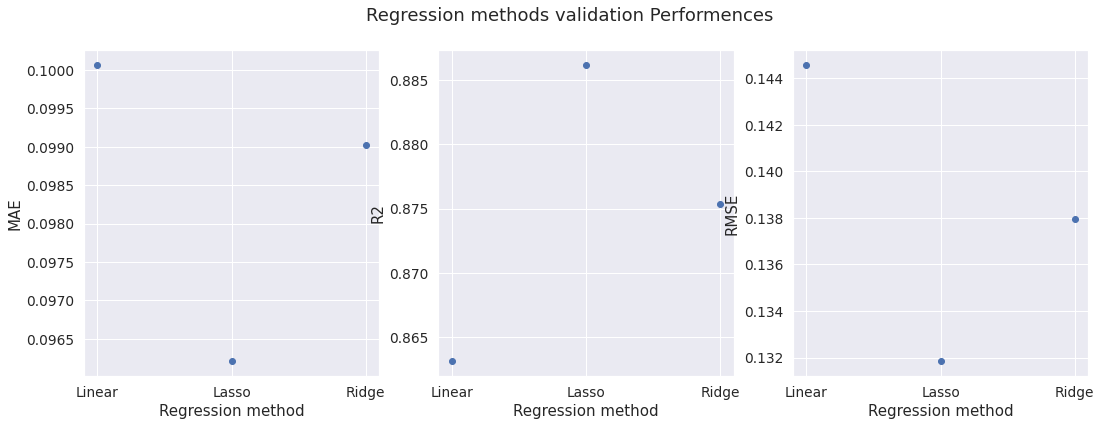

([0.10006474088155695, 0.09620443178794563, 0.09901775362784261],
 [0.8631016656584987, 0.8861658626195547, 0.8753828883125705],
 [0.14456962816853136, 0.1318299970714591, 0.13793256822089744])

In [262]:
# Data initialize
# x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
# Data split
Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
# Train and evaluate diffrent models
evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid)

We can notice that the Ridge and the Lasso Regression are more beneficial comparing to the linear Regerrsion.

## 3.4 Hyperparameters

### 3.4.1 impute_method

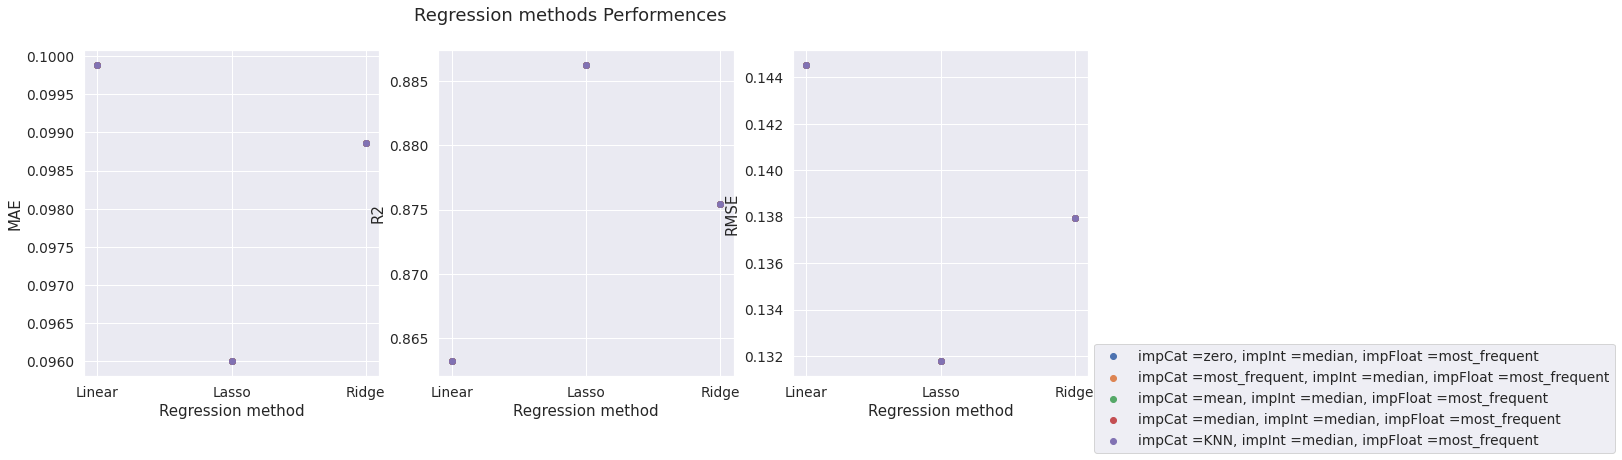

In [263]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

impCat_vec = ["zero", "most_frequent", "mean", "median", "KNN"]
# impInt_vec = ["zero", "most_frequent", "mean", "median", "KNN"]
# impFloat_vec = ["zero", "most_frequent", "mean", "median", "KNN"]

# impCat_vec =["most_frequent"]
impInt_vec = ["median"]
impFloat_vec = ["most_frequent"]

for impCat_item in impCat_vec:
  for impInt_item in impInt_vec:
    for impFloat_item in impFloat_vec:
      # Data initialize
      # x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
      x_train, y_train, x_test = initialize_data(impCat = impCat_item, impInt = impInt_item, impFloat = impFloat_item, catEnc = "Factorazie")
      # Data split
      Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
      # Train and evaluate diffrent models
      MAE_array_valid, R2_array_valid, RMSE_array_valid = evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=False)

      axs[0].scatter(["Linear","Lasso", "Ridge"], MAE_array_valid, label ="impCat ={}, impInt ={}, impFloat ={}".format(impCat_item,impInt_item,impFloat_item))
      axs[1].scatter(["Linear","Lasso", "Ridge"], R2_array_valid, label ="impCat ={}, impInt ={}, impFloat ={}".format(impCat_item,impInt_item,impFloat_item))
      axs[2].scatter(["Linear","Lasso", "Ridge"], RMSE_array_valid, label ="impCat ={}, impInt ={}, impFloat ={}".format(impCat_item,impInt_item,impFloat_item))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("R2")
axs[2].set_ylabel("RMSE")
axs[0].set_xlabel("Regression method")
axs[1].set_xlabel("Regression method")
axs[2].set_xlabel("Regression method")
fig.suptitle('Regression methods Performences')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='best', borderaxespad=0)
plt.show()

We can notice that highest R^2 score and lowest RMSE and MAE scores are performed by the orange dots i.e. setting the imputation on the float variabels to be "most frequent"

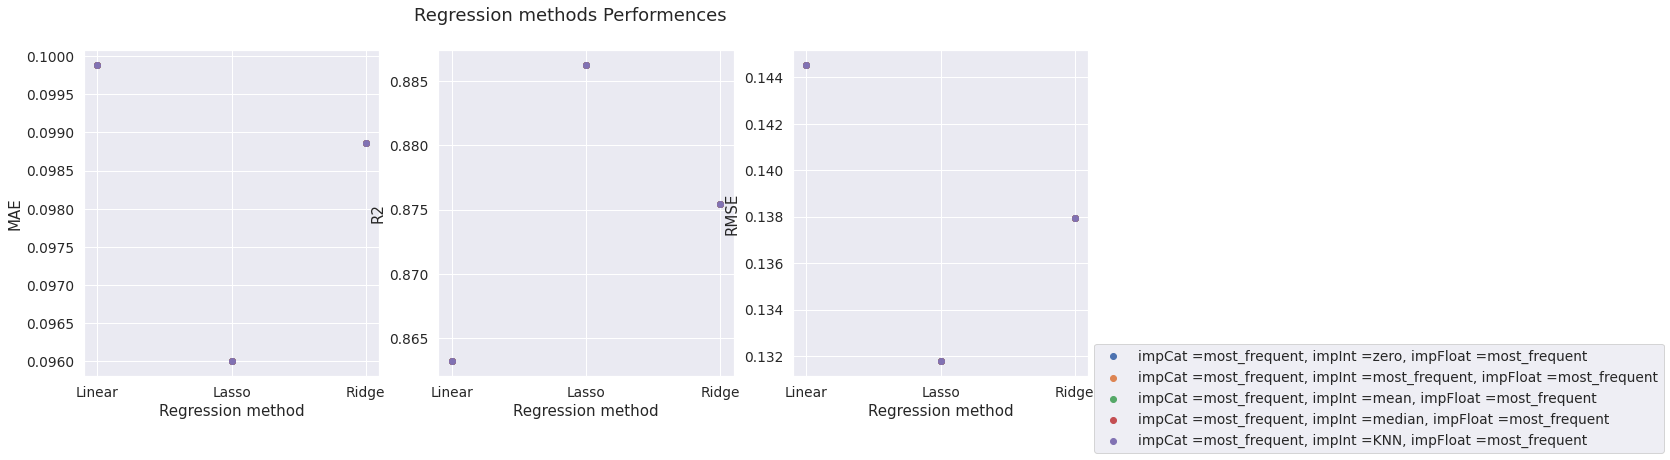

In [254]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# impCat_vec = ["zero", "most_frequent", "mean", "median", "KNN"]
impInt_vec = ["zero", "most_frequent", "mean", "median", "KNN"]
# impFloat_vec = ["zero", "most_frequent", "mean", "median", "KNN"]

impCat_vec =["most_frequent"]
# impInt_vec = ["median"]
impFloat_vec = ["most_frequent"]

for impCat_item in impCat_vec:
  for impInt_item in impInt_vec:
    for impFloat_item in impFloat_vec:
      # Data initialize
      # x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
      x_train, y_train, x_test = initialize_data(impCat = impCat_item, impInt = impInt_item, impFloat = impFloat_item, catEnc = "Factorazie")
      # Data split
      Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
      # Train and evaluate diffrent models
      MAE_array_valid, R2_array_valid, RMSE_array_valid = evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=False)

      axs[0].scatter(["Linear","Lasso", "Ridge"], MAE_array_valid, label ="impCat ={}, impInt ={}, impFloat ={}".format(impCat_item,impInt_item,impFloat_item))
      axs[1].scatter(["Linear","Lasso", "Ridge"], R2_array_valid, label ="impCat ={}, impInt ={}, impFloat ={}".format(impCat_item,impInt_item,impFloat_item))
      axs[2].scatter(["Linear","Lasso", "Ridge"], RMSE_array_valid, label ="impCat ={}, impInt ={}, impFloat ={}".format(impCat_item,impInt_item,impFloat_item))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("R2")
axs[2].set_ylabel("RMSE")
axs[0].set_xlabel("Regression method")
axs[1].set_xlabel("Regression method")
axs[2].set_xlabel("Regression method")
fig.suptitle('Regression methods Performences')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='best', borderaxespad=0)
plt.show()

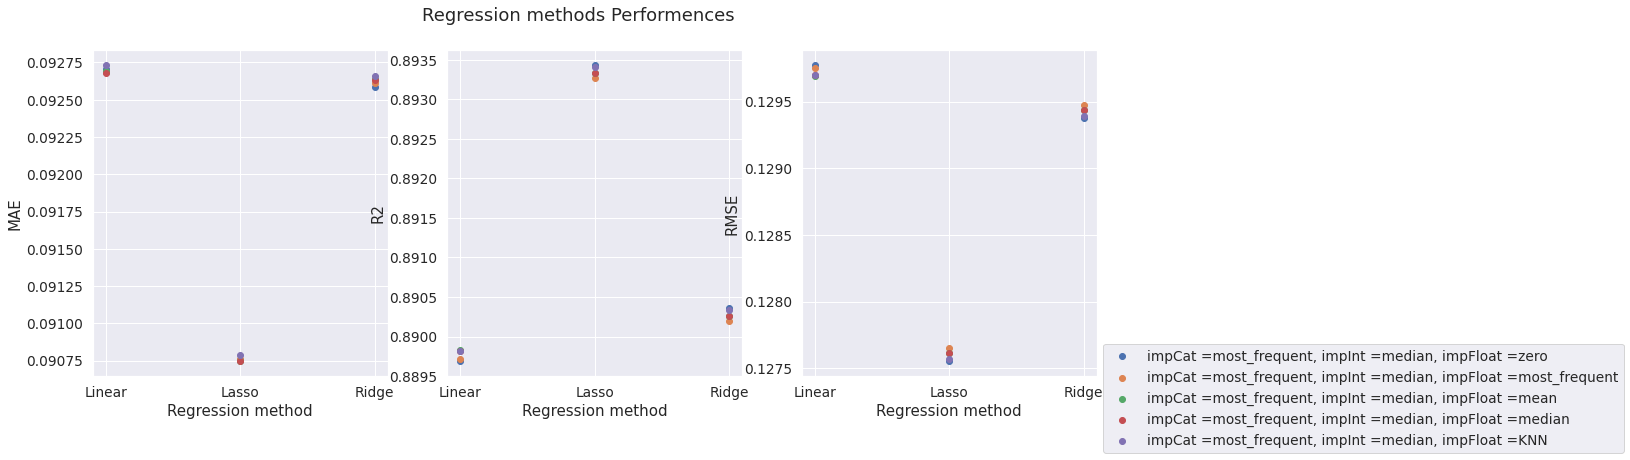

In [266]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# impCat_vec = ["zero", "most_frequent", "mean", "median", "KNN"]
# impInt_vec = ["zero", "most_frequent", "mean", "median", "KNN"]
impFloat_vec = ["zero", "most_frequent", "mean", "median", "KNN"]

impCat_vec =["most_frequent"]
impInt_vec = ["median"]
# impFloat_vec = ["most_frequent"]

for impCat_item in impCat_vec:
  for impInt_item in impInt_vec:
    for impFloat_item in impFloat_vec:
      # Data initialize
      # x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
      x_train, y_train, x_test = initialize_data(impCat = impCat_item, impInt = impInt_item, impFloat = impFloat_item, catEnc = "Label", K_val = 50)
      # Data split
      Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
      # Train and evaluate diffrent models
      MAE_array_valid, R2_array_valid, RMSE_array_valid = evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=False)

      axs[0].scatter(["Linear","Lasso", "Ridge"], MAE_array_valid, label ="impCat ={}, impInt ={}, impFloat ={}".format(impCat_item,impInt_item,impFloat_item))
      axs[1].scatter(["Linear","Lasso", "Ridge"], R2_array_valid, label ="impCat ={}, impInt ={}, impFloat ={}".format(impCat_item,impInt_item,impFloat_item))
      axs[2].scatter(["Linear","Lasso", "Ridge"], RMSE_array_valid, label ="impCat ={}, impInt ={}, impFloat ={}".format(impCat_item,impInt_item,impFloat_item))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("R2")
axs[2].set_ylabel("RMSE")
axs[0].set_xlabel("Regression method")
axs[1].set_xlabel("Regression method")
axs[2].set_xlabel("Regression method")
fig.suptitle('Regression methods Performences')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='best', borderaxespad=0)
plt.show()

There isnt much difference between the imputing methoed of the Categorical and the integer Variabels

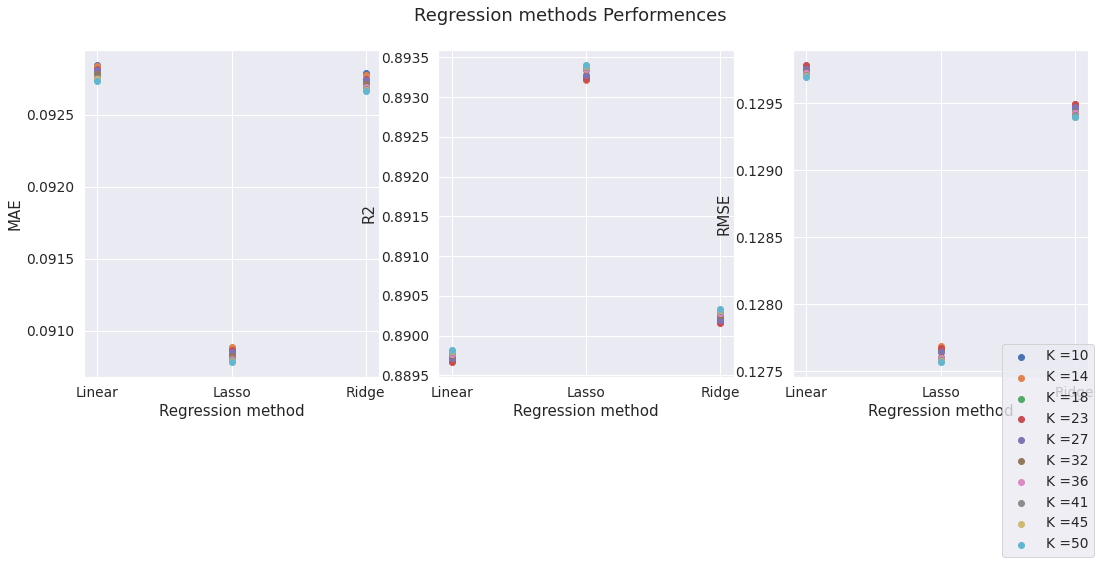

In [265]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

impCat_vec = "most_frequent"
impInt_vec = "median"
# impFloat_vec = ["zero", "most_frequent", "mean", "median", "KNN"]
# impInt_vec = ["median"]
impFloat_vec = "KNN"
for K_it in np.linspace(10,50,10, dtype= int):
# for K_it in [2,4,10,50]:
  # Data initialize
  # x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
  x_train, y_train, x_test = initialize_data(impCat = impCat_vec, impInt = impInt_vec, impFloat = impFloat_vec, catEnc = "Label", K_val=K_it)
  # Data split
  Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
  # Train and evaluate diffrent models
  MAE_array_valid, R2_array_valid, RMSE_array_valid = evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=False)
  axs[0].scatter(["Linear","Lasso", "Ridge"], MAE_array_valid, label ="K ={}".format(K_it))
  axs[1].scatter(["Linear","Lasso", "Ridge"], R2_array_valid, label ="K ={}".format(K_it))
  axs[2].scatter(["Linear","Lasso", "Ridge"], RMSE_array_valid, label ="K ={}".format(K_it))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("R2")
axs[2].set_ylabel("RMSE")
axs[0].set_xlabel("Regression method")
axs[1].set_xlabel("Regression method")
axs[2].set_xlabel("Regression method")
fig.suptitle('Regression methods Performences')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='best', borderaxespad=0)
plt.show()

We can notice that KNN at its finest scores still not preferable over setting most frequent imputing over the float featuers.

The best impute methods are: 
* **Categorical features** - there is no different
* **Int features** - there is no different
* **Float features** - most_frequent

### 3.4.2 Categorical encoding

The main difference between Factorize and label encoding is that label encoding sets the Major class in each categorical value to be the highest numerical value and the minor to be 0, in contrast to factorization which does the opposite!

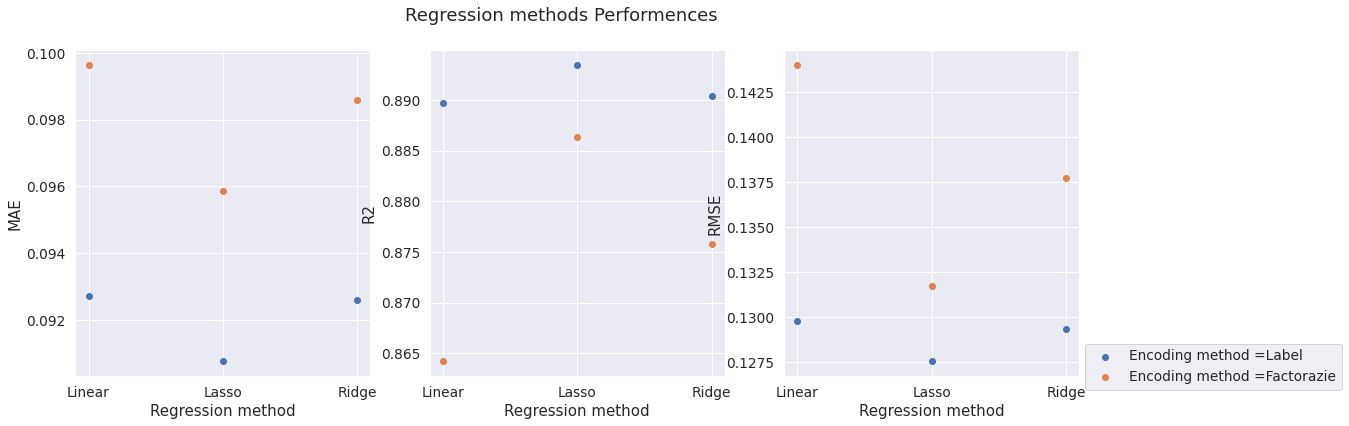

In [267]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

Encoding_methods = ["Label","Factorazie"]


for enc in Encoding_methods:
  # Data initialize
  # x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
  x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "zero", catEnc = enc)
  # Data split
  Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
  # Train and evaluate diffrent models
  MAE_array_valid, R2_array_valid, RMSE_array_valid = evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=False)

  axs[0].scatter(["Linear","Lasso", "Ridge"], MAE_array_valid, label ="Encoding method ={}".format(enc))
  axs[1].scatter(["Linear","Lasso", "Ridge"], R2_array_valid, label ="Encoding method ={}".format(enc))
  axs[2].scatter(["Linear","Lasso", "Ridge"], RMSE_array_valid, label ="Encoding method ={}".format(enc))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("R2")
axs[2].set_ylabel("RMSE")
axs[0].set_xlabel("Regression method")
axs[1].set_xlabel("Regression method")
axs[2].set_xlabel("Regression method")
fig.suptitle('Regression methods Performences')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='best', borderaxespad=0)
plt.show()

As we can notice, Factorizing the Categorical Features yield the best results so far

Linear Regression Model results:
performences over Train set:
MAE = 0.07958990737483856
R2 = 0.920561464253625
RMSE = 0.11024589854401971


performences over Validation set:
MAE = 0.0927041782394666
R2 = 0.8896860506302268
RMSE = 0.12977564574896697


Lasso Regression Model results:
performences over Train set:
MAE = 0.08099709419966478
R2 = 0.917739868353183
RMSE = 0.11218673953284536


performences over Validation set:
MAE = 0.09075290665517248
R2 = 0.8934351625154707
RMSE = 0.1275513165027555


Ridge Kfold Regression Model results:
performences over Train set:
MAE = 0.08016722165759914
R2 = 0.9195410714712543
RMSE = 0.11095169687815937


performences over Validation set:
MAE = 0.09258680182680637
R2 = 0.8903674088892328
RMSE = 0.12937424288946467




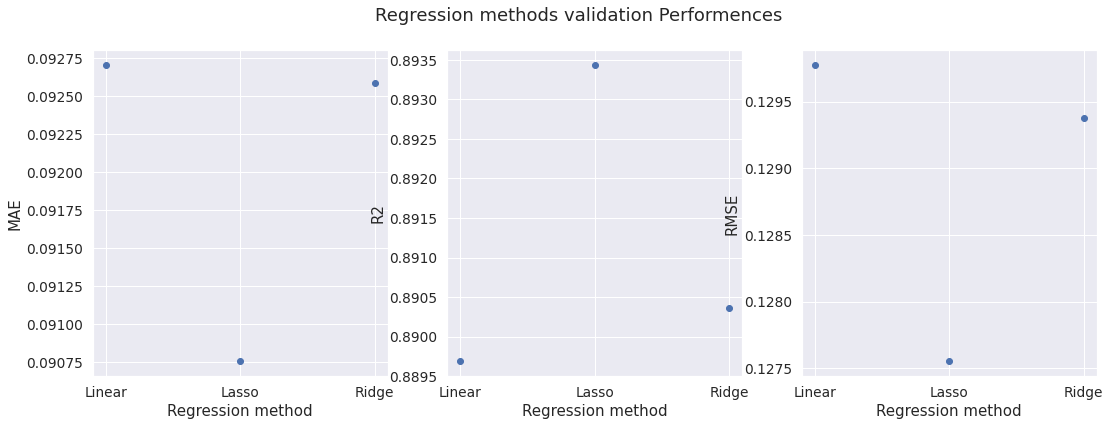

([0.0927041782394666, 0.09075290665517248, 0.09258680182680637],
 [0.8896860506302268, 0.8934351625154707, 0.8903674088892328],
 [0.12977564574896697, 0.1275513165027555, 0.12937424288946467])

In [271]:
# Data initialize
# x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "zero", catEnc = "Label")
# Data split
Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
# Train and evaluate diffrent models
evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid)

### 3.4.3 Normalize

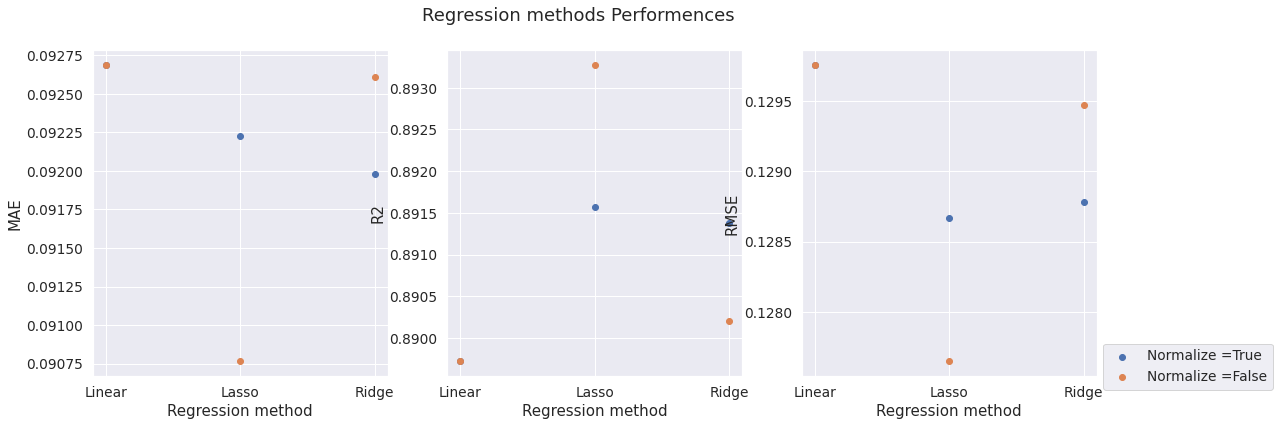

In [272]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

Normalize = [True,False]
for NORM in Normalize:
  # Data initialize
  # x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
  x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "most_frequent", catEnc = "Label", NORMALIZE=NORM)
  # Data split
  Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
  # Train and evaluate diffrent models
  MAE_array_valid, R2_array_valid, RMSE_array_valid = evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=False)

  axs[0].scatter(["Linear","Lasso", "Ridge"], MAE_array_valid, label ="Normalize ={}".format(NORM))
  axs[1].scatter(["Linear","Lasso", "Ridge"], R2_array_valid, label ="Normalize ={}".format(NORM))
  axs[2].scatter(["Linear","Lasso", "Ridge"], RMSE_array_valid, label ="Normalize ={}".format(NORM))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("R2")
axs[2].set_ylabel("RMSE")
axs[0].set_xlabel("Regression method")
axs[1].set_xlabel("Regression method")
axs[2].set_xlabel("Regression method")
fig.suptitle('Regression methods Performences')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='best', borderaxespad=0)
plt.show()

### 3.4.4 Correlation Removal

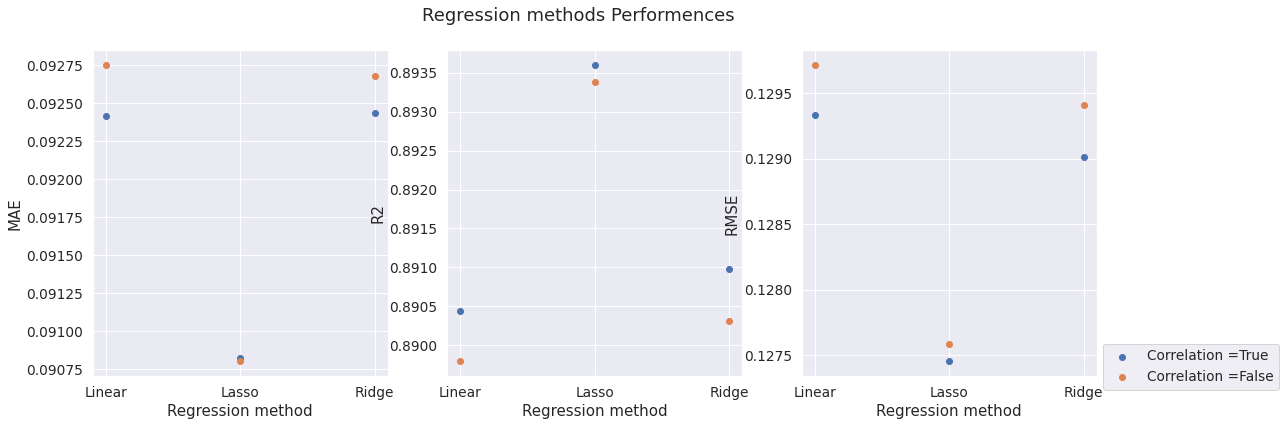

In [273]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

Correlation = [True,False]
for CORR in Correlation:
  # Data initialize
  # x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
  x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN",catEnc = "Label",K_val=41,CORR=CORR)
  # Data split
  Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
  # Train and evaluate diffrent models
  MAE_array_valid, R2_array_valid, RMSE_array_valid = evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=False)

  axs[0].scatter(["Linear","Lasso", "Ridge"], MAE_array_valid, label ="Correlation ={}".format(CORR))
  axs[1].scatter(["Linear","Lasso", "Ridge"], R2_array_valid, label ="Correlation ={}".format(CORR))
  axs[2].scatter(["Linear","Lasso", "Ridge"], RMSE_array_valid, label ="Correlation ={}".format(CORR))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("R2")
axs[2].set_ylabel("RMSE")
axs[0].set_xlabel("Regression method")
axs[1].set_xlabel("Regression method")
axs[2].set_xlabel("Regression method")
fig.suptitle('Regression methods Performences')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='best', borderaxespad=0)
plt.show()

Removing only **GarageArea** fetures

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

Correlation = [True,False]
for CORR in Correlation:
  # Data initialize
  # x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
  x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "most_frequent",CORR=CORR)
  # Data split
  Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
  # Train and evaluate diffrent models
  MAE_array_valid, R2_array_valid, RMSE_array_valid = evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=False)

  axs[0].scatter(["Linear","Lasso", "Ridge"], MAE_array_valid, label ="Correlation ={}".format(CORR))
  axs[1].scatter(["Linear","Lasso", "Ridge"], R2_array_valid, label ="Correlation ={}".format(CORR))
  axs[2].scatter(["Linear","Lasso", "Ridge"], RMSE_array_valid, label ="Correlation ={}".format(CORR))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("R2")
axs[2].set_ylabel("RMSE")
axs[0].set_xlabel("Regression method")
axs[1].set_xlabel("Regression method")
axs[2].set_xlabel("Regression method")
fig.suptitle('Regression methods Performences')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='best', borderaxespad=0)
plt.show()

Removing only **TotRmsAbvGrd** fetures

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

Correlation = [True,False]
for CORR in Correlation:
  # Data initialize
  # x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
  x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "most_frequent",CORR=CORR)
  # Data split
  Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
  # Train and evaluate diffrent models
  MAE_array_valid, R2_array_valid, RMSE_array_valid = evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=False)

  axs[0].scatter(["Linear","Lasso", "Ridge"], MAE_array_valid, label ="Correlation ={}".format(CORR))
  axs[1].scatter(["Linear","Lasso", "Ridge"], R2_array_valid, label ="Correlation ={}".format(CORR))
  axs[2].scatter(["Linear","Lasso", "Ridge"], RMSE_array_valid, label ="Correlation ={}".format(CORR))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("R2")
axs[2].set_ylabel("RMSE")
axs[0].set_xlabel("Regression method")
axs[1].set_xlabel("Regression method")
axs[2].set_xlabel("Regression method")
fig.suptitle('Regression methods Performences')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='best', borderaxespad=0)
plt.show()

Removing only **1stFlrSF** fetures

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

Correlation = [True,False]
for CORR in Correlation:
  # Data initialize
  # x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
  x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "most_frequent",CORR=CORR)
  # Data split
  Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
  # Train and evaluate diffrent models
  MAE_array_valid, R2_array_valid, RMSE_array_valid = evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid, ifPrint=False)

  axs[0].scatter(["Linear","Lasso", "Ridge"], MAE_array_valid, label ="Correlation ={}".format(CORR))
  axs[1].scatter(["Linear","Lasso", "Ridge"], R2_array_valid, label ="Correlation ={}".format(CORR))
  axs[2].scatter(["Linear","Lasso", "Ridge"], RMSE_array_valid, label ="Correlation ={}".format(CORR))

axs[0].set_ylabel("MAE")
axs[1].set_ylabel("R2")
axs[2].set_ylabel("RMSE")
axs[0].set_xlabel("Regression method")
axs[1].set_xlabel("Regression method")
axs[2].set_xlabel("Regression method")
fig.suptitle('Regression methods Performences')
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='best', borderaxespad=0)
plt.show()

So we will remove **TotRmsAbvGrd** feture in order to improve the model results

### Best Performences so Far

Linear Regression Model results:
performences over Train set:
MAE = 0.08008547147915204
R2 = 0.9168826128964732
RMSE = 0.11272327079014133


performences over Validation set:
MAE = 0.09261742305527308
R2 = 0.8965800461599667
RMSE = 0.12581350996558024


Lasso Regression Model results:
performences over Train set:
MAE = 0.08164067676760965
R2 = 0.9142595417715449
RMSE = 0.11448815082083152


performences over Validation set:
MAE = 0.09090780932859299
R2 = 0.8992468110308268
RMSE = 0.12418081598608725


Ridge Kfold Regression Model results:
performences over Train set:
MAE = 0.08063904555227845
R2 = 0.9160236277012953
RMSE = 0.11330424872857159


performences over Validation set:
MAE = 0.09248326230255126
R2 = 0.8969066776770456
RMSE = 0.12561467427292888




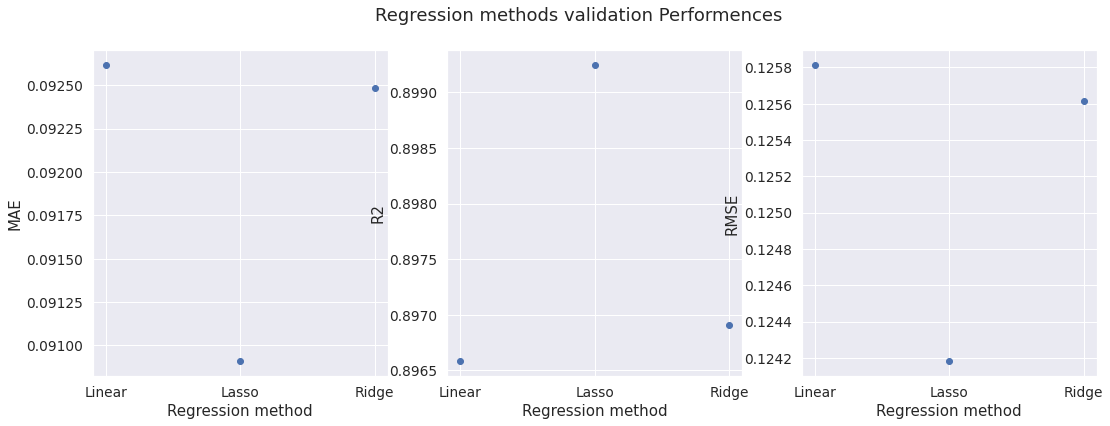

([0.09261742305527308, 0.09090780932859299, 0.09248326230255126],
 [0.8965800461599667, 0.8992468110308268, 0.8969066776770456],
 [0.12581350996558024, 0.12418081598608725, 0.12561467427292888])

In [275]:
# Data initialize
# x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median", impFloat = "KNN")
# x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median",
#                                            impFloat = "most_frequent", catEnc = "Label",
#                                            NORMALIZE=False, CORR = True)

x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median",
                                           impFloat = "zero", catEnc = "Label",
                                           NORMALIZE=False, CORR = True)

# Data split
Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)
# Train and evaluate diffrent models
evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid)

## 4. Section 4: Submission

Linear Regression Model results:
performences over Train set:
MAE = 0.07937617016270244
R2 = 0.9200839349430048
RMSE = 0.11057676294803365


performences over Validation set:
MAE = 0.09235654400137963
R2 = 0.8903307908168205
RMSE = 0.12939584704853868


Lasso Regression Model results:
performences over Train set:
MAE = 0.0809126550613863
R2 = 0.9172641613364165
RMSE = 0.1125106575970111


performences over Validation set:
MAE = 0.09078949059083725
R2 = 0.893634415673583
RMSE = 0.1274320140457183


Ridge Kfold Regression Model results:
performences over Train set:
MAE = 0.07997673631555623
R2 = 0.9190552059024175
RMSE = 0.11128619344942219


performences over Validation set:
MAE = 0.092369748469376
R2 = 0.8910149684982767
RMSE = 0.12899159384861417




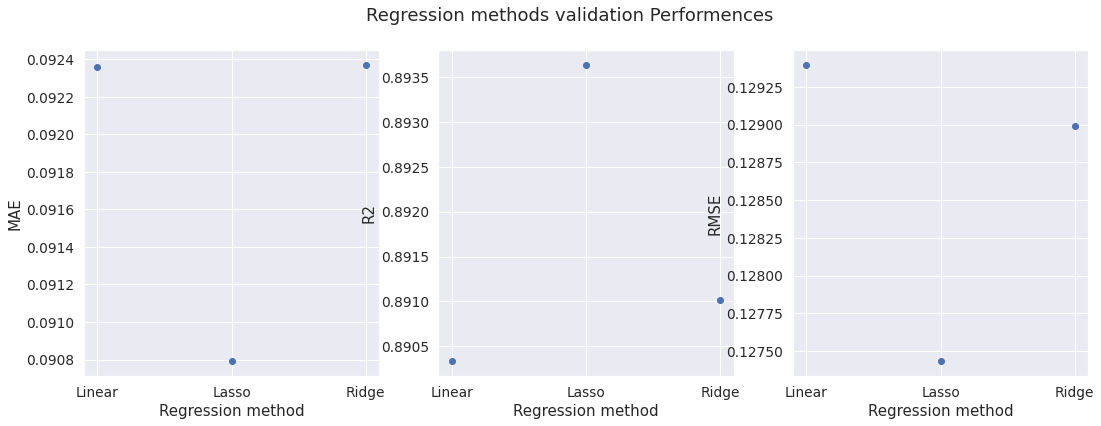

        Id      SalePrice
0     1461  119931.422625
1     1462  154657.198387
2     1463  177489.629361
3     1464  192704.925215
4     1465  185152.861106
...    ...            ...
1454  2915   97506.219592
1455  2916   85476.842288
1456  2917  167016.611994
1457  2918  118912.356504
1458  2919  234578.897600

[1459 rows x 2 columns]


In [282]:
# Feature engineering
# x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median",
#                                            impFloat = "zero", catEnc = "Factorazie",
#                                            NORMALIZE=False, CORR = True)
x_train, y_train, x_test = initialize_data(impCat = "most_frequent", impInt = "median",
                                           impFloat = "zero", catEnc = "Label",
                                           NORMALIZE=False, CORR = True)
# Data split
Xtrain, Xvalid, ytrain, yvalid = train_test_split(x_train, y_train, test_size = 0.3, random_state = 0)
# Model implemantion
R = Regression_model(x_train, y_train)
# R.Linear_reg()
R.Lasso_reg([1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
# prediction
pred_test = R.model.predict(x_test)
# target correction
target = np.expm1(pred_test)
evaluate_model(data_train=Xtrain, data_valid=Xvalid, target_train=ytrain, target_valid=yvalid)
# make submission dataframe

test = pd.read_csv(main_path + '/test.csv')
submission =  pd.DataFrame(test['Id'])
submission['SalePrice'] = target
print(submission)
main_path + '/sample_submission_test.csv'

submission.to_csv(main_path + '/sample_submission_test_1.csv', index=False)


### ++++++++++

**Categorical Value:**

MAE = 0.09198478447624521
R2 = 0.7993810645978225
RMSE = 0.17606104103589937


**Int Values:**

MAE = 0.09198478447624521
R2 = 0.7993810645978225
RMSE = 0.17606104103589937

**float Values:**

K = 8
MAE = 0.09194339972473553
R2 = 0.7992661154371496
RMSE = 0.17611147289249104

K = 10
MAE = 0.09197296137523692
R2 = 0.7997209415512774
RMSE = 0.17591184162060375

**all KNN:**

K = 8
MAE = 0.09194339972473553
R2 = 0.7992661154371496
RMSE = 0.17611147289249104

K = 10
MAE = 0.09197296137523692
R2 = 0.7997209415512774
RMSE = 0.17591184162060375



**We can notice that applying KNN imputing is beneficail only when applied on float represented Variabels, and performs better then not using KNN at all *

Similarly, Best performences given by setting K =10. 

The main difference between Factorize and label encoding is that label encoding sets the Major class in each categorical value to be the highest numerical value and the minor to be 0, in contrast to factorization which does the opposite!

Factorize Encoding Results:

MAE = 0.09197296137523692
R2 = 0.7997209415512774
RMSE = 0.17591184162060375

Label Encoding Results:

MAE = 0.09113030833080774
R2 = 0.8066921745407033
RMSE = 0.17282319211095384
